# Advaned Data Analytics for Management Support - Final Assignment

## Table of Contents :
    1. Introduction
    2. Data loading & eyeballing
    3. Data cleaning
     3.1 Duplications
     3.2 Redundant features
     3.3 Missing values
     3.4 Text cleaning
    4. Feature engineering
     4.1 Feature retrieving
     4.2 Text features
     4.3 Feature analysis
    5. Benchmark models
     5.1 Data preparation
      5.1.1 Categorical variables preparation
      5.1.2 Text avriables preparation
     5.2 Linear Regression
     5.3 Random Forest
     5.4 XGboost
     5.5 Basic RNN
    6. NN Architechture
     6.1 LSTM model
     6.2 CNN model
     6.3 Full architechture
    7. Predictions
     7.1 Model application on full training set
     7.2 Predictions on test set
    8. Conclusion
     
    
      
     

---

## 1. Introduction

In this assigtment we will predict the price of listings in the city of London from the AirBnB website. AirBnB is an online marketplace for accomodation, in which users post properties owned by private people or companies. The user determines the price per night based on multiple factors, and the customers decide whether they are willing to rent the property for the listed price or not. 

Our task is to predict the listing price based on numerical/categorical features such as number of beds and zipcode, as well as textual features such as description. We will also use the separatly provided review list, in order to amplify the predictive power of our model.

A significant focus will be on using NLP models to harness any predictive ability from the texts. We will first analyze the train and text data, clean it and perform feature engineering. Then we will use different models as a comparison, continue to test different NLP models and then construct our NN architecure. Finally, we will predict the prices of the listings in our test data using the architecture created.

In [875]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import pickle
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy import stats
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from keras.layers import Embedding
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

---

## 2. Data loading and eyeballing

In [876]:
train = pd.read_csv("train.csv" , sep = ",")
test = pd.read_csv("test.csv" , sep = ",")

#As we will modify the dataset's features, keep also a copy of the original one 
train_orig = pd.read_csv("train.csv" , sep = ",")
test_orig = pd.read_csv("test.csv" , sep = ",")

In [877]:
print ( len(train.columns) , len(test.columns))

42 41


The train set seems to have an extra column. Let's find first which variable it is and also make sure that all other columns of the train and test sets are actually the same variables

In [878]:
train.columns.difference(test.columns)

Index(['price'], dtype='object')

The column missing in the test set is the price which we are going to predict, so it's not a concern. All other variables are the same.

In [879]:
print("The train data has {} observations".format(len(train)))
print("The test data has {} observations".format(len(test)))

The train data has 55284 observations
The test data has 29769 observations


In [880]:
train.head(5)

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_id,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,listing_id
0,Attic Room in historic Greenwich,The room does not have a door but its own disc...,Double room available in historic royal Greenw...,The room does not have a door but its own disc...,business,NaN,Parking is restricted in London. Visitors park...,no shoes on carpets no food in attic room no o...,https://a0.muscache.com/im/pictures/20045164/7...,2167992,...,95.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.37,9Q1RD6H7IO
1,Lovely Garden Studio Private Access,"Garden studio with private entrance, 5 minutes...","Beautiful studio with a king size bed, a sofa ...","Garden studio with private entrance, 5 minutes...",none,Crouch End is a very hip and friendly neighbou...,Walk across the street to the W3 bus stop and ...,We'd love it if you would remove your shoes at...,https://a0.muscache.com/im/pictures/8d1ddcdc-f...,16148175,...,99.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,2.97,6XDPZPGLSR
2,Comfi apartment 2 close to wimbledon tennis court,NaN,NaN,NaN,none,NaN,NaN,1- No party or event allowed. 2-No smoking ins...,https://a0.muscache.com/im/pictures/e7e4a740-d...,272000199,...,84.0,9.0,9.0,10.0,10.0,9.0,8.0,strict_14_with_grace_period,1.73,SND9OPN6IY
3,Luxury room in the heart of London - SW4,Luxury first floor Victorian split level maiso...,"Your room will be fully furnished, and it will...",Luxury first floor Victorian split level maiso...,none,"Gail coffee shop, just round the corner as wel...",Happy to advise on things to do in London and ...,- Check-in after 18:30pm and no later than 20:...,https://a0.muscache.com/im/pictures/7c2b2fcc-e...,3361233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexible,NaN,SE3B7BXN9G
4,Excellent city Apartment with Private Patio,"NEW luxury apartment, with private outside pat...","A modern, well-equipped, cosy apartment close ...","NEW luxury apartment, with private outside pat...",none,NaN,NaN,"I am very happy for your visit, but please car...",https://a0.muscache.com/im/pictures/ca1494da-f...,94317022,...,100.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.32,E0C82VK0VF


In [881]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55284 entries, 0 to 55283
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   name                         55270 non-null  object 
 1   summary                      52330 non-null  object 
 2   space                        38403 non-null  object 
 3   description                  53558 non-null  object 
 4   experiences_offered          55284 non-null  object 
 5   neighborhood_overview        35778 non-null  object 
 6   transit                      35477 non-null  object 
 7   house_rules                  31906 non-null  object 
 8   picture_url                  55284 non-null  object 
 9   host_id                      55284 non-null  int64  
 10  host_since                   55173 non-null  object 
 11  host_response_time           37482 non-null  object 
 12  host_response_rate           37482 non-null  object 
 13  host_is_superhos

Change the type of our variables, so we are left only with categorical, boolean and float variables. Later will also look into dropping redundant variables, but for now we assume they are all valuable and re-type them if neccessary. 

In [882]:
cat_variables = ['experiences_offered' , 'host_response_time' , 'neighbourhood_cleansed' , 'property_type' , 'room_type' , 
                 'bathrooms' , 'bedrooms' , 'beds' , 'bed_type' , 'guests_included', 'cancellation_policy']
train[cat_variables] = train[cat_variables].astype('category')
test[cat_variables] = test[cat_variables].astype('category')

#Change listing_id to category too, we'll use that later to match with the reviews from the 'reviews' dataframe.
train['listing_id'] = train['listing_id'].astype('category')
test['listing_id'] = test['listing_id'].astype('category')

In [883]:
train.host_is_superhost = train.host_is_superhost.map({'t' : 1 , 'f' : 0})
train.host_has_profile_pic = train.host_has_profile_pic.map({'t' : 1 , 'f' : 0})
train.host_identity_verified = train.host_identity_verified.map({'t' : 1 , 'f' : 0})

test.host_is_superhost = test.host_is_superhost.map({'t' : 1 , 'f' : 0})
test.host_has_profile_pic = test.host_has_profile_pic.map({'t' : 1 , 'f' : 0})
test.host_identity_verified = test.host_identity_verified.map({'t' : 1 , 'f' : 0}) 



train.host_is_superhost = train.host_is_superhost.astype('bool')
train.host_has_profile_pic = train.host_has_profile_pic.astype('bool')
train.host_identity_verified = train.host_identity_verified.astype('bool')

test.host_is_superhost = test.host_is_superhost.astype('bool')
test.host_has_profile_pic = test.host_has_profile_pic.astype('bool')
test.host_identity_verified = test.host_identity_verified.astype('bool')

int_vars = train.select_dtypes(include = ['int64']).columns
train[int_vars] = train[int_vars].astype('float64')
int_vars = test.select_dtypes(include = ['int64']).columns
test[int_vars] = test[int_vars].astype('float64')

train['host_response_rate'] = train['host_response_rate'].str.rstrip("%").astype(float)/100
test['host_response_rate'] = test['host_response_rate'].str.rstrip("%").astype(float)/100

In [884]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55284 entries, 0 to 55283
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   name                         55270 non-null  object  
 1   summary                      52330 non-null  object  
 2   space                        38403 non-null  object  
 3   description                  53558 non-null  object  
 4   experiences_offered          55284 non-null  category
 5   neighborhood_overview        35778 non-null  object  
 6   transit                      35477 non-null  object  
 7   house_rules                  31906 non-null  object  
 8   picture_url                  55284 non-null  object  
 9   host_id                      55284 non-null  float64 
 10  host_since                   55173 non-null  object  
 11  host_response_time           37482 non-null  category
 12  host_response_rate           37482 non-null  float64 
 13  h

___

## 3. Data Cleaning



---

### 3.1 Duplicates

First, we will check if we have duplications in our data. The variable we can use for this purpose is the listing_id, which should be different for every listing.

In [885]:
train[train.listing_id == train.listing_id[0]]

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_id,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,listing_id
0,Attic Room in historic Greenwich,The room does not have a door but its own disc...,Double room available in historic royal Greenw...,The room does not have a door but its own disc...,business,NaN,Parking is restricted in London. Visitors park...,no shoes on carpets no food in attic room no o...,https://a0.muscache.com/im/pictures/20045164/7...,2167992.0,...,95.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.37,9Q1RD6H7IO


In [886]:
test[test.listing_id == test.listing_id[0]]

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_id,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,listing_id
0,Ladbroke Grove Stylish Portobello Apartment,"Large, bright and contemporary flat located in...",NaN,"Large, bright and contemporary flat located in...",none,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/9e15bc56-a...,28086957.0,...,96.0,10.0,10.0,10.0,10.0,10.0,10.0,flexible,1.89,0FEMC4VA5U


Good, so we have no duplicates, neither in the train set nor in the test set.

---

### 3.2 Redundant Features

Our data comes with a large amount of features. Some of them are intiutively redundant and hold very low predictive power or no power at all. We will drop these features now (later we will perform a deeper feature analysis and hopefully further reduce the number of features).

In [887]:
train.drop(columns = ['picture_url' , 'host_id', 'neighbourhood'  ,'zipcode' , 'latitude' , 'longitude' , 'accommodates' , 
          'reviews_per_month' , 'host_since'] , inplace = True)
test.drop(columns = ['picture_url' , 'host_id', 'neighbourhood' , 'zipcode', 'latitude' , 'longitude' , 'accommodates' , 
         'reviews_per_month', 'host_since'] , inplace = True)


We drop 'neighbourhood' and 'zipcode' as we use the feature 'neighbourhood_cleansed' instead. We also drop 'accommodates' as we use 
the feature 'guests', which reasonably holds more predictive power ('accommodates' is the limit of the feature 'guests' and so is fixed. The price will change however as the guest number changes). 'reviews per month' is dropped as we will create a feature
'number of reviews' later on. The rest of the dropped features were dropped simply based on common sense.

---

### 3.3 Missing Values

In [888]:
train.isnull().sum()

name                              14
summary                         2954
space                          16881
description                     1726
experiences_offered                0
neighborhood_overview          19506
transit                        19807
house_rules                    23378
host_response_time             17802
host_response_rate             17802
host_is_superhost                  0
host_total_listings_count        111
host_has_profile_pic               0
host_identity_verified             0
neighbourhood_cleansed             0
property_type                      0
room_type                          0
bathrooms                         70
bedrooms                          62
beds                             262
bed_type                           0
amenities                          0
price                              0
guests_included                    0
review_scores_rating           13415
review_scores_accuracy         13448
review_scores_cleanliness      13442
r

In [889]:
# The NaN in the text variables are of type float, which will cause problems with our text cleaning functions later on. Therefore, we will change all NaN values in our text variables 
# to an empty string.

text_list = ['name' , 'summary' , 'space' , 'description' , 'neighborhood_overview' , 'transit' , 'house_rules']
for name in text_list :
    train[name].fillna('' , inplace = True)
    test[name].fillna('' , inplace = True)

For the following features we conduct the following NaN handling: <br>
Host response time - change to mode <br>
Host response rate - change to median <br>
Review scores rating - change to mean <br>
Total listing count change to 1 <br>
Bathrooms to number of bedrooms <br>
bedrooms to number of beds <br>
beds to number of bedrooms <br>

In [890]:
train.host_response_time.fillna((train.host_response_time.mode()[0]) , inplace = True)
train.host_response_rate.fillna((train.host_response_rate.mean()) , inplace = True)
train.review_scores_rating .fillna((train.review_scores_rating.mean()) , inplace = True)
train.host_total_listings_count.fillna(1, inplace = True)

#Change category variables to float in order to easily replace NaN with numbers
train['bathrooms'] = train['bathrooms'].astype('float64')
train['bedrooms'] = train['bedrooms'].astype('float64')
train['beds'] = train['beds'].astype('float64')
train['guests_included'] = train['guests_included'].astype('float64')

train.loc[train['beds'].isnull(),'beds'] = np.ceil(train['guests_included']/2)
train.loc[train['bedrooms'].isnull(),'bedrooms'] = train['beds']
train.loc[train['bathrooms'].isnull(),'bathrooms'] = train['bedrooms']

train['bathrooms'] = train['bathrooms'].astype('category')
train['bedrooms'] = train['bedrooms'].astype('category')
train['beds'] = train['beds'].astype('category')
train['guests_included'] = train['guests_included'].astype('category')

In [891]:
test.host_response_time.fillna((train.host_response_time.mode()[0]) , inplace = True)
test.host_response_rate.fillna((train.host_response_rate.mean()) , inplace = True)
test.review_scores_rating.fillna((train.review_scores_rating.mean()) , inplace = True)
test.host_total_listings_count.fillna(1, inplace = True)

test['bathrooms'] = test['bathrooms'].astype('float64')
test['bedrooms'] = test['bedrooms'].astype('float64')
test['beds'] = test['beds'].astype('float64')
test['guests_included'] = test['guests_included'].astype('float64')

test.loc[test['beds'].isnull(),'beds'] = np.ceil(test['guests_included']/2)
test.loc[test['bedrooms'].isnull(),'bedrooms'] = test['beds']
test.loc[test['bathrooms'].isnull(),'bathrooms'] = test['bedrooms']

test['bathrooms'] = test['bathrooms'].astype('category')
test['bedrooms'] = test['bedrooms'].astype('category')
test['beds'] = test['beds'].astype('category')
test['guests_included'] = test['guests_included'].astype('category')

---

### 3.4 Text Cleaning

In [893]:
def get_wordnet_pos(word):
    """Map POS tag to first character for lemmatization"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def clean_text(text):
    
    # remove newlines
    clean_text = text.replace("\n", " ")
    clean_text = clean_text.replace("\xa0", " ")
    # remove URLs
    clean_text = re.sub(r'http\S+', '', clean_text)
    clean_text = re.sub(r'www\.\S+', '', clean_text)
    # remove non-alphabetic characters
    clean_text = re.sub("[^a-zA-Z]", " ", clean_text)
    # remove html content
    clean_text = BeautifulSoup(clean_text, "html.parser").get_text()

    # fix contractions
    clean_text = re.sub(r"['’]ll", " will", clean_text)
    clean_text = re.sub(r"['’]ve", " have", clean_text)
    clean_text = re.sub(r"['’]re", " are", clean_text)
    clean_text = re.sub(r"['’]d", " would", clean_text)
    clean_text = re.sub(r"['’]m", " am", clean_text)
    clean_text = re.sub(r"(?i)there['’]s", "there is", clean_text)
    clean_text = re.sub(r"(?i)that['’]s", "that is", clean_text)
    clean_text = re.sub(r"(?i)it['’]s", "it is", clean_text)
    clean_text = re.sub(r"(?i)he['’]s", "he is", clean_text)
    clean_text = re.sub(r"can['’]t", "cannot", clean_text)
    clean_text = re.sub(r"won['’]t", "will not", clean_text)
    clean_text = re.sub(r"n['’]t", " not", clean_text)
    clean_text = clean_text.replace("gonna", "going to")
    clean_text = clean_text.replace("wanna", "want to")
    clean_text = clean_text.replace("gotta", "got to")
    clean_text = clean_text.replace('\s+', ' ')
    
    # tokenize the sentences
    words = word_tokenize(clean_text.lower())
    # filter stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # lemmatize each word to its lemma
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in words]
    return lemmatized_words



In [894]:
def text_feature_cleaner(feature):
    print('*' * 40)
    print('Cleaning {} texts of feature {}.'.format(feature.shape[0] , feature.name))
    clean_feature = feature.apply(clean_text)
    detokenized_feature = [TreebankWordDetokenizer().detokenize(article) for article in clean_feature]
    new_feature = pd.Series( detokenized_feature, index=feature.index, dtype="str")
    return new_feature

In [620]:
text_features = ['name' , 'summary' , 'space' , 'description' , 'neighborhood_overview' , 'transit', 
                 'house_rules', 'amenities']
for t in text_features:
    train[t] = text_feature_cleaner(train[t])
    test[t] = text_feature_cleaner(test[t])


****************************************
Cleaning 55284 texts of feature name.
****************************************
Cleaning 29769 texts of feature name.
****************************************
Cleaning 55284 texts of feature summary.
****************************************
Cleaning 29769 texts of feature summary.
****************************************
Cleaning 55284 texts of feature space.
****************************************
Cleaning 29769 texts of feature space.
****************************************
Cleaning 55284 texts of feature description.
****************************************
Cleaning 29769 texts of feature description.
****************************************
Cleaning 55284 texts of feature neighborhood_overview.
****************************************
Cleaning 29769 texts of feature neighborhood_overview.
****************************************
Cleaning 55284 texts of feature transit.
****************************************
Cleaning 29769 texts of feature

---

## 4. Feature Engineering

---

### 4.1 Feature Retrieving 

First, let's utilize our extra dataset which contains the reviews. By matching the 'listing_id' on both datasets we can count the number of reviews our listings have. The number of reviews combined with the reviews's ratings may posses a strong predictive value.

In [900]:
reviews_df = pd.read_csv("reviews.csv" , sep = ",")
reviews_df['listing_id'] = reviews_df['listing_id'].astype('category')

In [901]:
review_value_count = reviews_df['listing_id'].value_counts()
train['number_of_reviews'] = train['listing_id'].map(review_value_count)
test['number_of_reviews'] = test['listing_id'].map(review_value_count)

# Fill n/a with the value zero, has these are simply observations that did'nt have any reviews in the review list.
train['number_of_reviews'].fillna(0 , inplace = True)
test['number_of_reviews'].fillna(0 , inplace = True)

---

### 4.2 Text Features

We have multiple text features. The current setting will make the neural network we will build later more cumbersome, so we will consolidate them as much as possible.

In [625]:
train['summary'][0:5]

0    room door discreet staircase light airy open p...
1    garden studio private entrance minute crouch e...
2                                                     
3    luxury first floor victorian split level maiso...
4    new luxury apartment private outside patio gre...
Name: summary, dtype: object

In [626]:
train['description'][0:5]

0    room door discreet staircase light airy open p...
1    garden studio private entrance minute crouch e...
2                                                     
3    luxury first floor victorian split level maiso...
4    new luxury apartment private outside patio gre...
Name: description, dtype: object

Both features contain exactly the same data. As we saw earlier, 'space' has many more missing values compared to 'description'. Let's see if we can fill up some of 'description' missing values from the 'space' feature 

In [627]:
null_spaces = np.array(np.where(train_orig['space'].isnull()))
null_description = np.array(np.where(train_orig['description'].isnull()))

not_in = np.setdiff1d(null_description, null_spaces)
not_in

array([], dtype=int64)

Unfortunately we don't have additional values in the 'space' feature to cover fro some of 'description' missing values. We will move on to remove the feature 'space'

In [902]:
train.drop(columns = 'space' , axis = 1 ,inplace = True)
test.drop(columns = 'space' , axis = 1 ,inplace = True)

Moving forward , the features 'description' and 'summary' are basically one big text cut into two. They hold more or less the same information, and in the Airbnb website the two are displayed together when the user clicks on 'read more'. Therefore, we can combine the two into a new feature.
Also, the feature 'name' can reasonably be combined with these features, as it also describes the listing.
We will create a feature named 'overview' which is a combination of all three features

In [903]:
train['overview'] = train['name'] + " " + train['summary'] + " " + train['description']
test['overview'] = test['name'] + " " + test['summary'] + " " + test['description']


train.drop(columns = ['name' , 'description' , 'summary'] , axis = 1 ,inplace = True)
test.drop(columns = ['name' , 'description' , 'summary'] , axis = 1 ,inplace = True)

---

### 4.3 Feature analysis

Our datasets contains many features, some of which might be of very little value to us. In this case, it would be better to filter out some more features in addition to the irrelevant ones dropped earlier.

Let's have a look at the review scoring. These are likely features with strong predictive power, but the 7 features should be highly correlated. It is also possible that the score rating is simply an average of all other features or close to that. Therefore, if our assumption is right, we can keep the feature 'review_score_rating' and drop the rest.

In [631]:
train.iloc[0:5,20:27]

,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,listing_id,number_of_reviews
0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,9Q1RD6H7IO,187.0
1,10.0,10.0,10.0,10.0,moderate,6XDPZPGLSR,138.0
2,10.0,10.0,9.0,8.0,strict_14_with_grace_period,SND9OPN6IY,11.0
3,NaN,NaN,NaN,NaN,flexible,SE3B7BXN9G,0.0
4,10.0,10.0,10.0,10.0,strict_14_with_grace_period,E0C82VK0VF,14.0


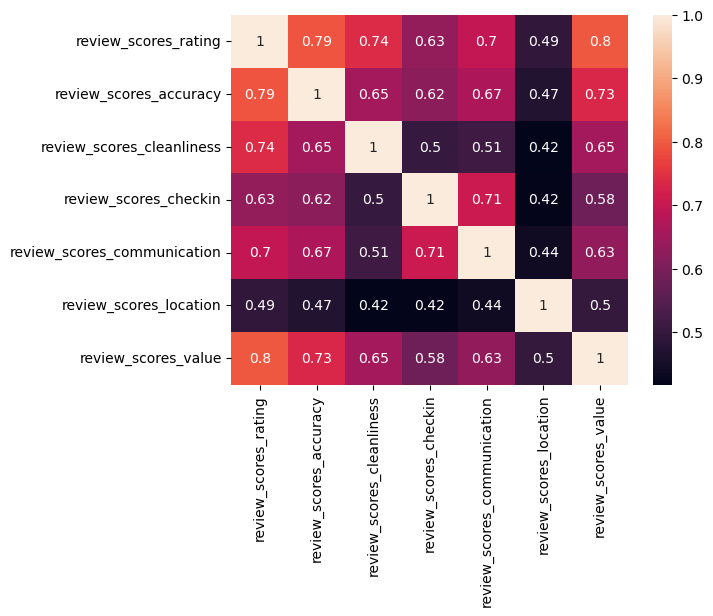

In [632]:
df_reviews = train.iloc[:,20:27]
df_reviews['review_scores_rating'] = df_reviews['review_scores_rating']/10
corr_mat = df_reviews.corr()
sns.heatmap(corr_mat , annot = True)
plt.show()

In [904]:
train['scores_average'] = train[['review_scores_accuracy' , 'review_scores_cleanliness', 'review_scores_checkin' , 'review_scores_communication' , 'review_scores_location' , 'review_scores_value']].mean(axis =1)
train['review_scores_rating'].corr(train['scores_average'])

0.8717074783429386

The 'review score rating' feature is very close to the average of the all other review score features. Therefore, we can just it as the aggregated data of the other 6 features and drop them, keeping only the total rating feature

In [905]:
train = train.drop(columns = ['review_scores_accuracy' , 'review_scores_cleanliness', 'review_scores_checkin' , 'review_scores_communication' , 'review_scores_location' , 'review_scores_value'])
test = test.drop(columns = ['review_scores_accuracy' , 'review_scores_cleanliness', 'review_scores_checkin' , 'review_scores_communication' , 'review_scores_location' , 'review_scores_value'])
train = train.drop(['scores_average'] , axis = 1)

We will move on to feature selection of our categorical / numerical. Our dataset has many variables, some of which look intutively irrelevant (removed before), and some are questionable. For this purpose, we will use the stepwise regression method. In order to do so, we will first split our train data, standrize the variables and normalize our target variable as much as possible.

Let's have a look at the target variable

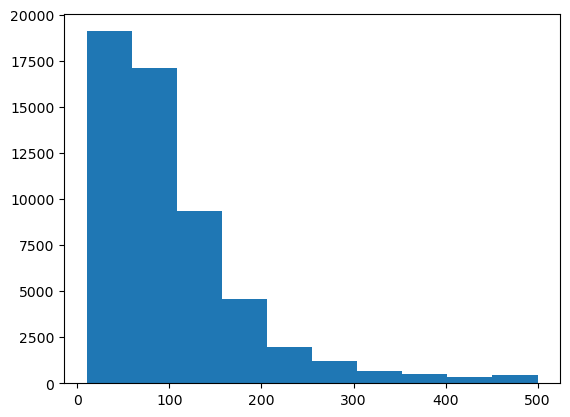

In [635]:
plt.hist(train['price'])
plt.show()

Our data does not look normal at all. We have a long right tail with few very expensive listings. This might be a problem for the learning of the models we will train later on.Let's try to transform it to a distribution that is closer to normal by log transform.

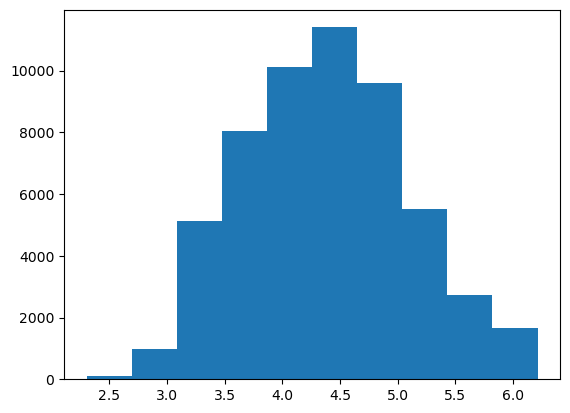

In [636]:
plt.hist(np.log(train['price']))
plt.show()

Looks much better! we will move on to transform our target variable to log scale. We will need to make sure to get the exponential of the prediction of our final model in order to get the prediction on the normal scale.

In [906]:
train['price'] = np.log(train['price'])

In [907]:
X1 = train.drop(['price'] , axis = 1)
Y1 = train[['price']]
X_train, X_val, y_train, y_val = train_test_split(X1, Y1, test_size=0.20, random_state=100)

Standardize our numerical variables - number_of_reviews ,review_score_rating, host_response_rate and price

In [908]:
mean_number_reviews = X_train['number_of_reviews'].mean(axis = 0)
std_number_reviews = X_train['number_of_reviews'].std(axis = 0)
mean_rating = X_train['review_scores_rating'].mean(axis = 0)
std_rating = X_train['review_scores_rating'].std(axis = 0)
mean_listings =X_train['host_total_listings_count'].mean(axis = 0)
std_listings = X_train['host_total_listings_count'].std(axis = 0)
mean_price =y_train['price'].mean()
std_price = y_train['price'].std()

In [909]:
X_train['number_of_reviews'] = (X_train['number_of_reviews'] - mean_number_reviews) / std_number_reviews
X_train['review_scores_rating'] = (X_train['review_scores_rating'] - mean_rating) / std_rating
X_train['host_total_listings_count'] = (X_train['host_total_listings_count'] - mean_listings) / std_listings
y_train = (y_train - mean_price) / std_price

#Scale validation set with training set mean & standard deviation
X_val['number_of_reviews'] = (X_val['number_of_reviews'] - mean_number_reviews) / std_number_reviews
X_val['review_scores_rating'] = (X_val['review_scores_rating'] - mean_rating) / std_rating
X_val['host_total_listings_count'] = (X_val['host_total_listings_count'] - mean_listings) / std_listings
y_val = (y_val - mean_price) / std_price




Now we can move on to our stepwise regression feature selection. We will the the built-in function from the mlxtend library.

In [910]:
X_train_dummies = pd.get_dummies(X_train, columns=["experiences_offered","host_response_time", 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms',  'bedrooms',
       'beds', 'bed_type', 'guests_included' , 'cancellation_policy'])
X_train_dummies.drop(columns = ['overview' , 'neighborhood_overview', 'transit', 'house_rules','listing_id','amenities'] , inplace = True)


X_val_dummies = pd.get_dummies(X_train, columns=["experiences_offered","host_response_time", 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms',  'bedrooms',
       'beds', 'bed_type', 'guests_included' , 'cancellation_policy'])
X_val_dummies.drop(columns = ['overview' , 'neighborhood_overview', 'transit', 'house_rules','listing_id','amenities'] , inplace = True)



In [642]:
lrm = LinearRegression()
sfs = SFS(lrm, 
           k_features=(3,30), 
           forward=True, 
           floating=False, 
           scoring='neg_mean_squared_error')
sfs = sfs.fit(X_train_dummies , y_train)

In [643]:
print('best combination (MSE: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_names_))

best combination (MSE: -0.359): ('host_total_listings_count', 'review_scores_rating', 'number_of_reviews', 'neighbourhood_cleansed_Camden', 'neighbourhood_cleansed_City of London', 'neighbourhood_cleansed_Croydon', 'neighbourhood_cleansed_Hackney', 'neighbourhood_cleansed_Hammersmith and Fulham', 'neighbourhood_cleansed_Islington', 'neighbourhood_cleansed_Kensington and Chelsea', 'neighbourhood_cleansed_Lambeth', 'neighbourhood_cleansed_Lewisham', 'neighbourhood_cleansed_Richmond upon Thames', 'neighbourhood_cleansed_Southwark', 'neighbourhood_cleansed_Tower Hamlets', 'neighbourhood_cleansed_Waltham Forest', 'neighbourhood_cleansed_Wandsworth', 'neighbourhood_cleansed_Westminster', 'property_type_Boutique hotel', 'property_type_Hostel', 'property_type_Hotel', 'room_type_Entire home/apt', 'room_type_Hotel room', 'bathrooms_2.0', 'bedrooms_0.0', 'bedrooms_1.0', 'bedrooms_2.0', 'bedrooms_3.0', 'beds_1.0', 'guests_included_1.0')



As expected the neighbourhood variable takes most of the chosen features, as it is valuable and has many different categories. We can also see that 'host_total_listings_count', 'review_scores_rating', 'number_of_reviews' and some categories from 'property_type', 'room_type' ,'bathrooms', 'bedrooms', 'beds' ,'guests_included' are selected.
To verify, we can rerun the model without the neighbourhood category and check if our results change significantly.

In [644]:
X_train_dummies2 = pd.get_dummies(X_train, columns=["experiences_offered","host_response_time", 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified', 'property_type', 'room_type', 'bathrooms',  'bedrooms',
       'beds', 'bed_type', 'guests_included' , 'cancellation_policy'])
X_train_dummies2 .drop(columns = ['neighbourhood_cleansed', 'overview' ,'neighborhood_overview', 'transit', 'house_rules','listing_id','amenities'] , inplace = True)


In [645]:
lrm = LinearRegression()
sfs2 = SFS(lrm, 
           k_features=(3,10), 
           forward=True, 
           floating=False, 
           scoring='neg_mean_squared_error')
sfs2 = sfs.fit(X_train_dummies2 , y_train)

In [646]:
print('best combination (MSE: %.3f): %s\n' % (sfs2.k_score_, sfs2.k_feature_names_))

best combination (MSE: -0.408): ('host_total_listings_count', 'review_scores_rating', 'number_of_reviews', 'host_response_time_within a day', 'property_type_Boutique hotel', 'property_type_Hostel', 'property_type_Hotel', 'property_type_House', 'property_type_Serviced apartment', 'property_type_Townhouse', 'room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Shared room', 'bathrooms_2.0', 'bathrooms_2.5', 'bathrooms_3.0', 'bathrooms_3.5', 'bathrooms_4.0', 'bathrooms_4.5', 'bedrooms_0.0', 'bedrooms_1.0', 'bedrooms_2.0', 'bedrooms_3.0', 'beds_0.0', 'beds_1.0', 'beds_2.0', 'guests_included_1.0', 'cancellation_policy_strict_14_with_grace_period', 'cancellation_policy_super_strict_30', 'cancellation_policy_super_strict_60')



We get a pretty much similar result. These results also go hand in hand with our intuition (e.g variables such has 'host_has_profile_pic' probably doesn't affect the price much). We will proceed from now with the above mentioned variables, and drop some more redundant variable:
'experiences_offered','host_response_time','host_response_rate', 'host_is_superhost','host_has_profile_pic', 'host_identity_verified', 'cancellation_policy'

With beds and bedrooms both selected, we can also keep only one of the two as they are stronly correlated.

In [647]:
train['bedrooms'].corr(train['beds'])

0.706357777850045

In [911]:
X_train_filtered = X_train.copy().drop(columns = ['experiences_offered','host_response_time','host_response_rate', 'host_is_superhost',
                        'host_has_profile_pic', 'host_identity_verified', 'cancellation_policy','bed_type','beds'])
X_val_filtered = X_val.copy().drop(columns = ['experiences_offered','host_response_time','host_response_rate', 'host_is_superhost',
                        'host_has_profile_pic', 'host_identity_verified', 'cancellation_policy','bed_type','beds'])

___

## 5. Bencmark Models

---

### 5.1 Data preparation

#### 5.1.1 Categorical variables preparation

Before we can implement our benchmark models, we will need to pre-process our data so it's in the right form for model fitting. Models such as the linear regression and random forest require dummy variables. As we have many categories, we will consolidate some features's categories to reduce the number of dummy variables.

In [649]:
print("Number of dummy variables before cleaning: {}".format(len(X_train_filtered['bedrooms'].cat.categories) + len(X_train_filtered['bathrooms'].cat.categories) + len(X_train_filtered['guests_included'].cat.categories) +
       len(X_train_filtered['property_type'].cat.categories) + len(X_train_filtered['neighbourhood_cleansed'].cat.categories)))

Number of dummy variable before cleaning: 119


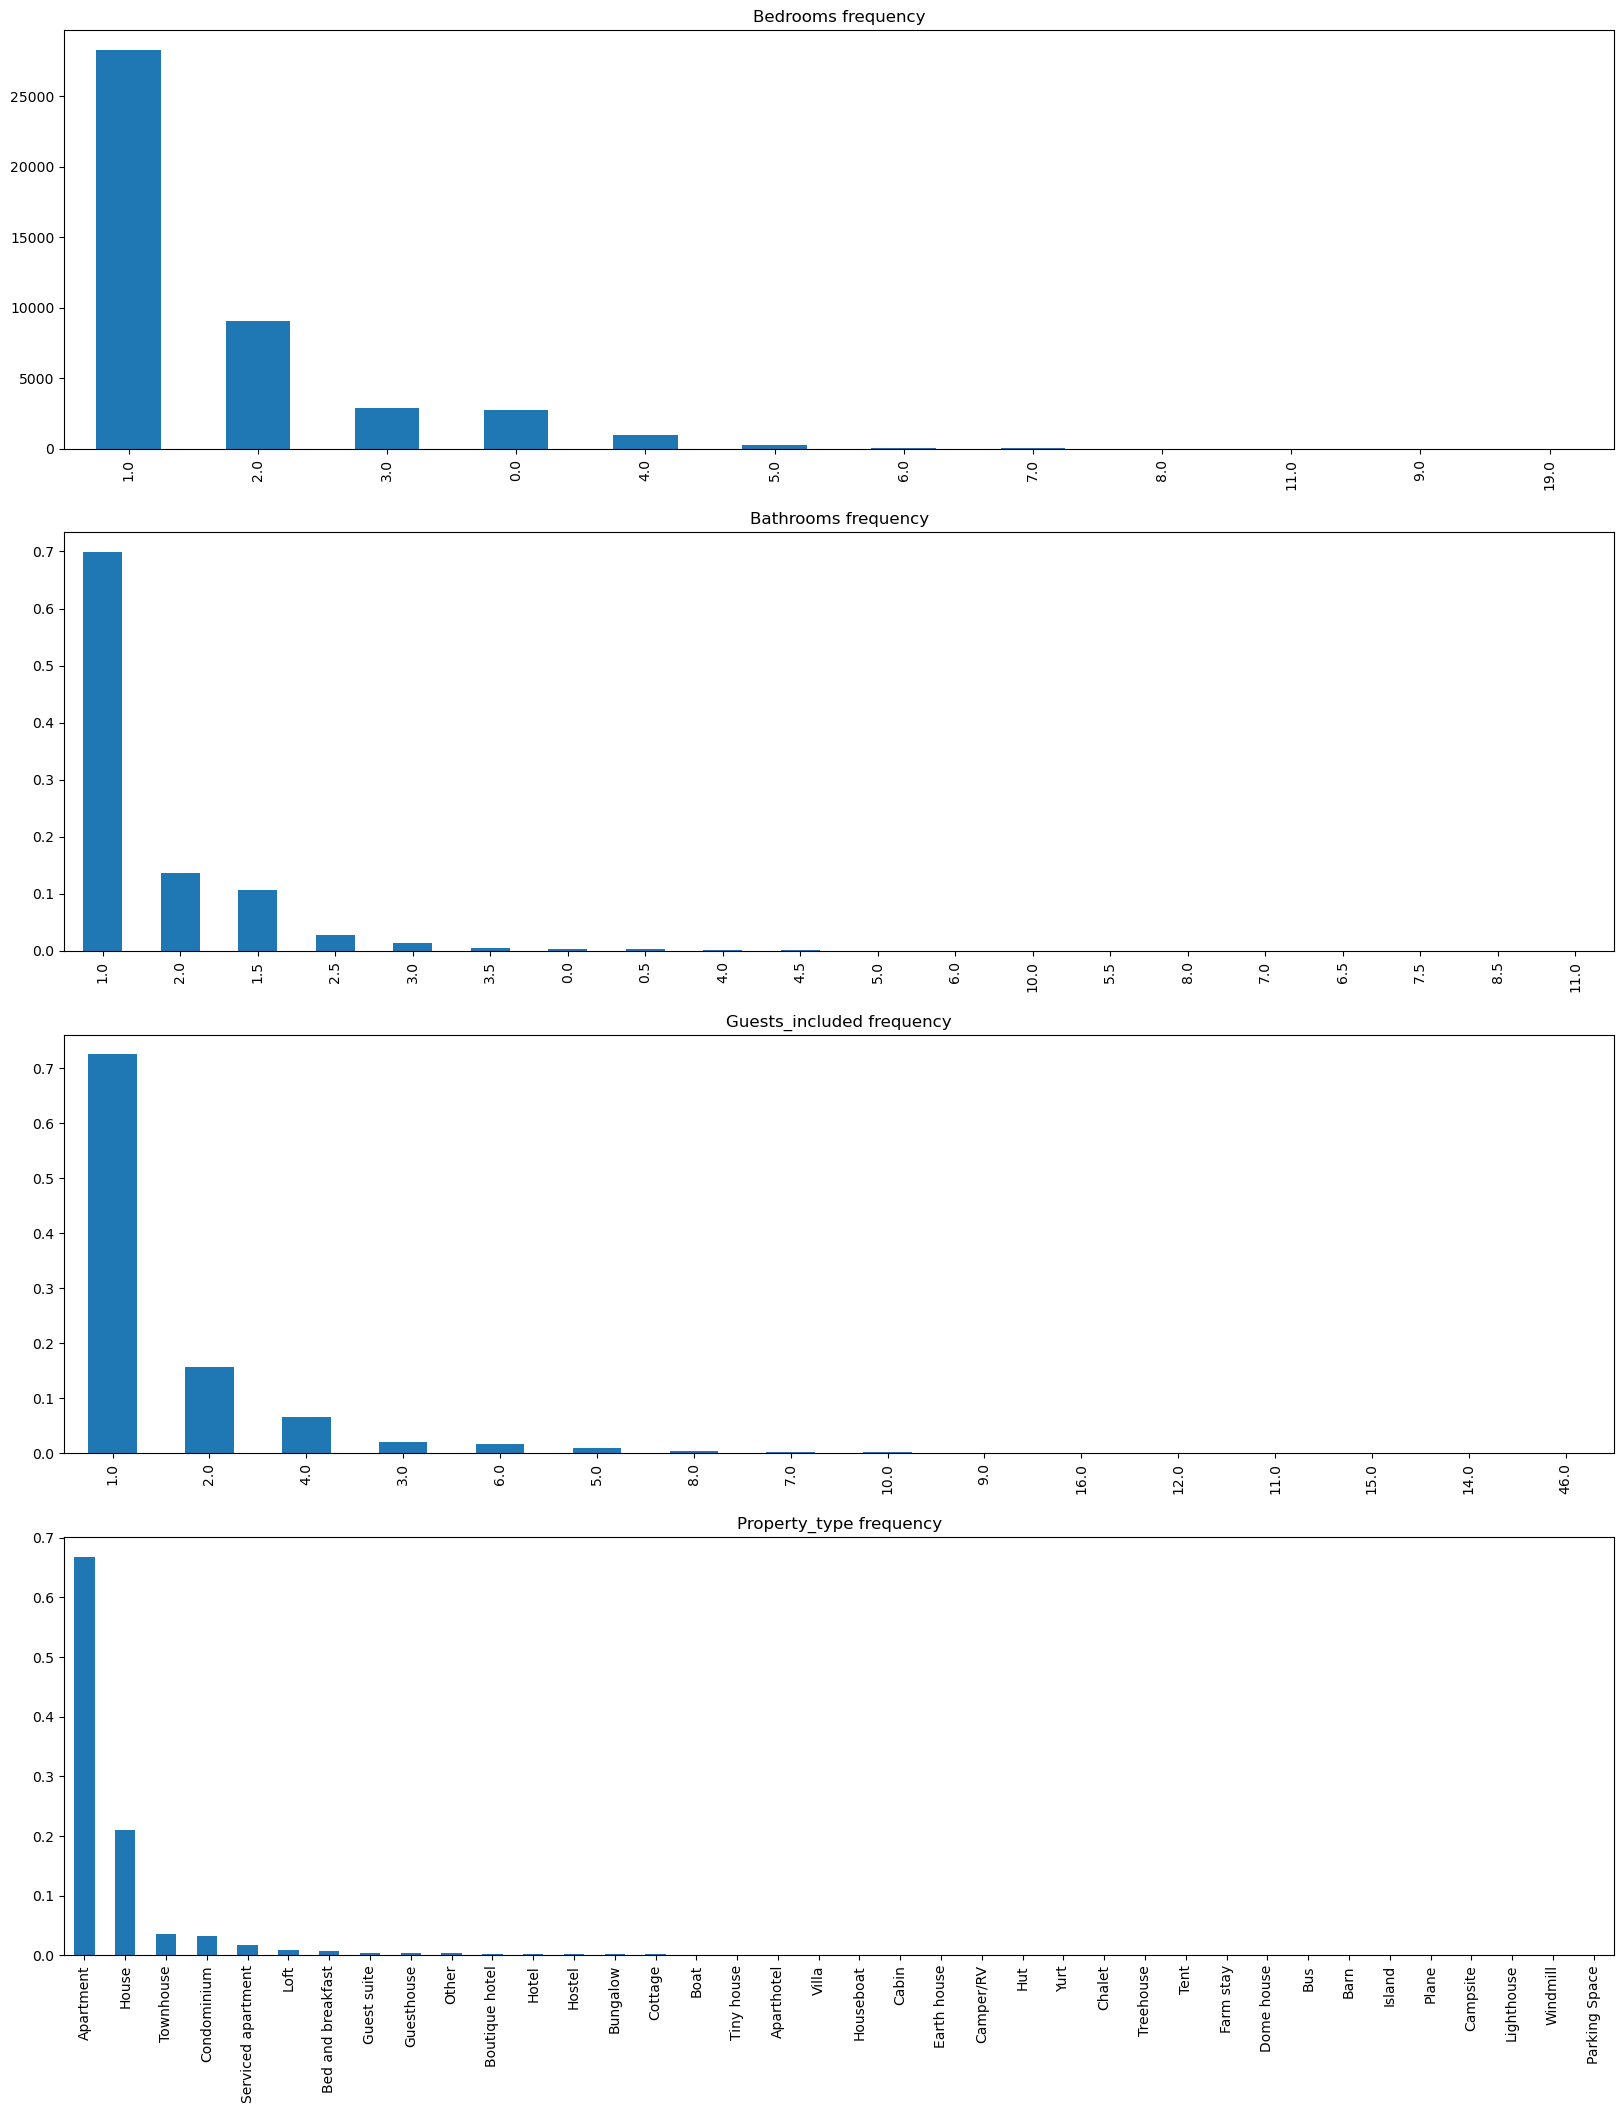

In [838]:
fig,ax = plt.subplots(4, figsize=(20,25))

X_train_filtered['bedrooms'].value_counts().plot(kind = "bar", ax=ax[0]).set_title("Bedrooms frequency")

X_train_filtered['bathrooms'].value_counts(normalize= True).plot(kind = "bar" , ax = ax[1]).set_title("Bathrooms frequency")

X_train_filtered['guests_included'].value_counts(normalize= True).plot(kind = "bar" , ax = ax[2]).set_title("Guests_included frequency")

X_train_filtered['property_type'].value_counts(normalize= True).plot(kind = "bar" , ax = ax[3]).set_title("Property_type frequency")

plt.show()

In [912]:
X_train_filtered['bedrooms'] = X_train_filtered['bedrooms'].replace({5.0 : "5.0+" , 6.0 : "5.0+", 7.0  : "5.0+" , 8.0  : "5.0+", 9.0  : "5.0+" , 11.0 : "5.0+",19.0 : "5.0+"})
X_train_filtered['bathrooms'] = X_train_filtered['bathrooms'].replace({0.0 : 1.0 , 0.5 : 1.0 , 3.5 : "3.5+" , 4.0 : "3.5+", 4.5 : "3.5+" , 5.0 : "3.5+" , 5.5 : "3.5+" , 6.0 : "3.5+",
                                                                       6.5 : "3.5+", 7.0 : "3.5+", 7.5 : "3.5+" , 8.0 : "3.5+", 8.5 : "3.5+", 10.0 : "3.5+" , 11.0 : "3.5+"})
X_train_filtered['guests_included'] = X_train_filtered['guests_included'].replace({7.0 : "7.0+" , 8.0 : "7.0+" , 8.0 : "7.0+", 9.0 : "7.0+", 10.0 : "7.0+" , 11.0 : "7.0+" , 
                                                                                   12.0 : "7.0+" , 14.0 : "7.0+", 15.0 : "7.0+" , 16.0 : "7.0+" , 46.0 : "7.0+"})                                                                                                                                      
categories_to_keep = ['Apartment', 'House' , 'Townhouse' , 'Condominium' , 'Serviced apartment']
X_train_filtered['property_type'] = X_train_filtered['property_type'].where(X_train_filtered['property_type'].isin(categories_to_keep), 'Other')
X_train_filtered['property_type'] = pd.Categorical(X_train_filtered['property_type'] , categories=categories_to_keep + ['Other'])



X_val_filtered['bedrooms'] = X_val_filtered['bedrooms'].replace({5.0 : "5.0+" , 6.0 : "5.0+", 7.0  : "5.0+" , 8.0  : "5.0+", 9.0  : "5.0+" , 11.0 : "5.0+",19.0 : "5.0+"})                                                                       
X_val_filtered['bathrooms'] = X_val_filtered['bathrooms'].replace({0.0 : 1.0 , 0.5 : 1.0 , 3.5 : "3.5+" , 4.0 : "3.5+", 4.5 : "3.5+" , 5.0 : "3.5+" , 5.5 : "3.5+" , 6.0 : "3.5+",
                                                                    6.5 : "3.5+", 7.0 : "3.5+", 7.5 : "3.5+" , 8.0 : "3.5+", 8.5 : "3.5+", 10.0 : "3.5+" , 11.0 : "3.5+"})
X_val_filtered['guests_included'] = X_val_filtered['guests_included'].replace({7.0 : "7.0+" , 8.0 : "7.0+" , 8.0 : "7.0+", 9.0 : "7.0+", 10.0 : "7.0+" , 11.0 : "7.0+" ,
                                                                               12.0 : "7.0+" , 14.0 : "7.0+", 15.0 : "7.0+" , 16.0 : "7.0+" , 46.0 : "7.0+"})
X_val_filtered['property_type'] = X_val_filtered['property_type'].where(X_val_filtered['property_type'].isin(categories_to_keep), 'Other')
X_val_filtered['property_type'] = pd.Categorical(X_val_filtered['property_type'] , categories=categories_to_keep + ['Other'])


The feature 'room_type' has only 4 categories, so we will leave it as it is.

In [ ]:
X_train_filtered['room_type'].value_counts()

Entire home/apt    24463
Private room       19003
Hotel room           426
Shared room          335
Name: room_type, dtype: int64

With neighbourhoods, we have a large number of categories, but unlike our other categorical variables, this variable is not ordinal. Therefore we will group the different neighbourhoods based on their average listing price

In [913]:
neighbourhoods = train.groupby("neighbourhood_cleansed")["price"].mean().reset_index()
neighbourhoods = neighbourhoods.sort_values(by='price', ascending=True)
neighbourhoods['price'] = np.exp(neighbourhoods['price'])
neighbourhoods

,neighbourhood_cleansed,price
25,Redbridge,46.723799
2,Bexley,47.134813
7,Croydon,47.544698
0,Barking and Dagenham,48.480091
28,Sutton,49.106322
14,Harrow,51.743335
16,Hillingdon,51.926534
4,Bromley,52.352494
9,Enfield,52.735789
15,Havering,53.044536


In [914]:
X_train_filtered['neighbourhood_cleansed'] = X_train_filtered['neighbourhood_cleansed'].replace({'City of London' : "City Center" , "Kensington and Chelsea" : "City Center", "Westminster" : "City Center", "Hammersmith and Fulham"  : "Fulham or similar", "Camden" : "Fulham or similar" , "Richmond or Thames" : "Fulham or similar" , 
                                                                                   "Islington" : "Fulham or similar" , "Wandsworth" : "Fulham or similar", "Southwark" : "Hackney or similar" , "Lambeth" : "Hackney or similar" , "Hackney" : "Hackney or similar", "Tower Hamlets" : "Hackney or similar", "Merton" :"Hackney or similar",
                                                                                                "Hounslow" : "Hackney or similar", "Brent" : "Newham or similar" , "Greenwich" : "Newham or similar", "Kingston upon Thames" : "Newham or similar", "Barnet" : "Newham or similar", "Newham" : "Newham or similar", "Ealing" : "Newham or similar", "Haringey" : "Newham or similar",
                                                                                                "Lewisham" : "Sutton or similar", "Waltham Forest" : "Sutton or similar", "Havering" : "Sutton or similar", "Enfield" : "Sutton or similar", "Bromley" : "Sutton or similar", "Hillingdon" :  "Sutton or similar", "Harrow" : "Sutton or similar" , "Sutton" : "Sutton or similar", "Barking and Dagenham" : "Sutton or similar",
                                                                                                "Croydon" : "Sutton or similar" , "Bexley" : "Sutton or similar", "Redbridge" : "Sutton or similar"})
X_val_filtered['neighbourhood_cleansed'] = X_val_filtered['neighbourhood_cleansed'].replace({'City of London' : "City Center" , "Kensington and Chelsea" : "City Center", "Westminster" : "City Center", "Hammersmith and Fulham"  : "Fulham or similar", "Camden" : "Fulham or similar" , "Richmond or Thames" : "Fulham or similar" , 
                                                                                   "Islington" : "Fulham or similar" , "Wandsworth" : "Fulham or similar", "Southwark" : "Hackney or similar" , "Lambeth" : "Hackney or similar" , "Hackney" : "Hackney or similar", "Tower Hamlets" : "Hackney or similar", "Merton" :"Hackney or similar",
                                                                                                "Hounslow" : "Hackney or similar", "Brent" : "Newham or similar" , "Greenwich" : "Newham or similar", "Kingston upon Thames" : "Newham or similar", "Barnet" : "Newham or similar", "Newham" : "Newham or similar", "Ealing" : "Newham or similar", "Haringey" : "Newham or similar",
                                                                                                "Lewisham" : "Sutton or similar", "Waltham Forest" : "Sutton or similar", "Havering" : "Sutton or similar", "Enfield" : "Sutton or similar", "Bromley" : "Sutton or similar", "Hillingdon" :  "Sutton or similar", "Harrow" : "Sutton or similar" , "Sutton" : "Sutton or similar", "Barking and Dagenham" : "Sutton or similar",
                                                                                                "Croydon" : "Sutton or similar" , "Bexley" : "Sutton or similar", "Redbridge" : "Sutton or similar"})

In [654]:
print("Number of dummy variables after cleaning: {}".format(len(X_train_filtered['bedrooms'].cat.categories) + len(X_train_filtered['bathrooms'].cat.categories) + len(X_train_filtered['guests_included'].cat.categories) +
       len(X_train_filtered['property_type'].cat.categories) + len(X_train_filtered['neighbourhood_cleansed'].cat.categories)))

Number of dummy variable after cleaning: 31


In [915]:
X_train_dummies = pd.get_dummies(X_train_filtered, columns =  ['property_type', 'room_type', 'bathrooms',  'bedrooms', 'guests_included', 'neighbourhood_cleansed'])
X_train_dummies.drop(columns = ['overview', 'neighborhood_overview', 'transit', 'house_rules','listing_id','amenities'] , inplace = True)
X_val_dummies = pd.get_dummies(X_val_filtered, columns =  ['property_type', 'room_type', 'bathrooms',  'bedrooms', 'guests_included', 'neighbourhood_cleansed'])
X_val_dummies.drop(columns = ['overview', 'neighborhood_overview', 'transit', 'house_rules','listing_id','amenities'] , inplace = True)

#### 5.1.2 Text variables preparation

As we will create a different vocabulary and layer for each feature, we will try to limit the number of our text features. 
Transit, house_rules and neighbourhood all have a very large number of missing values - almost half of our train set.
This will make it hard for our models to effecively use the prediction power of these features.
Neighbourhood overview can be partly modeled by our neighbourhood categorical variable. Also, the importance of transit and house rules, based on our prior knowledge, is not the highest. Due to these reasons, we will leave out these features.

In [1155]:
# Tokenize overview variable and pad based on the data. 
# Also, we extract the vocab length of the feature to get an idea of its size, in order to use it later 
tokenizer_overview = Tokenizer(oov_token=1)
tokenizer_overview.fit_on_texts(X_train['overview'])
overview_vocab = len(tokenizer_overview.word_index) + 1
X_tr_overview = tokenizer_overview.texts_to_sequences(X_train['overview'])
mean_overview_length = np.mean([len(overview) for overview in X_tr_overview])

print ("Overview vocab length : {} , Overview mean length : {}".format(overview_vocab , mean_overview_length))
max_overview_length = 300
X_tr_overview = pad_sequences(X_tr_overview, max_overview_length)

#Do the same for the validation set
X_val_overview = tokenizer_overview.texts_to_sequences(X_val['overview'])
X_val_overview = pad_sequences(X_val_overview, max_overview_length)

Overview vocab length : 28230 , Overview mean length : 118.00612747868949


In [917]:
# Tokenize amenities variable and pad based on the data. 
# Also, we extract the vocab length of the feature to get an idea of its size, in order to use it later 
tokenizer_amenities = Tokenizer(oov_token=1)
tokenizer_amenities.fit_on_texts(X_train['amenities'])
amenities_vocab = len(tokenizer_amenities.word_index) + 1
X_tr_amenities = tokenizer_amenities.texts_to_sequences(X_train['amenities'])
mean_amenities_length = np.mean([len(amenities) for amenities in X_tr_amenities])

print ("Amenities vocab length : {} , Amenities mean length : {}".format(amenities_vocab , mean_amenities_length))
max_amenities_length = 70
X_tr_amenities = pad_sequences(X_tr_amenities, max_amenities_length)

#Do the same for the validation set
X_val_amenities = tokenizer_amenities.texts_to_sequences(X_val['amenities'])
X_val_amenities = pad_sequences(X_val_amenities, max_amenities_length)

Amenities vocab length : 274 , Amenities mean length : 34.15838741040541


In [918]:
X_tr_overview = np.array(X_tr_overview)
X_tr_amenities = np.array(X_tr_amenities)

X_val_overview = np.array(X_val_overview)
X_val_amenities = np.array(X_val_amenities)

---

### 5.2 Linear Regression

In [919]:
regression = LinearRegression()
regression.fit(X_train_dummies, y_train)


regression_predictions = pd.DataFrame({"predictions": np.ravel(regression.predict(X_val_dummies)), "actual": y_val['price']})


regression_predictions['predictions'] = (regression_predictions['predictions'] * std_price) + mean_price
regression_predictions['actual'] = (regression_predictions['actual'] * std_price) + mean_price
regression_predictions['predictions'] = np.exp(regression_predictions['predictions'])
regression_predictions['actual'] = np.exp(regression_predictions['actual'])

print("R2: {}".format(regression.score(X_val_dummies, y_val['price'])))
print("RMSE: {}".format(np.sqrt(mean_squared_error(regression_predictions.actual, regression_predictions.predictions))))
print("MAE: {}".format(mean_absolute_error(regression_predictions.actual, regression_predictions.predictions)))



R2: 0.6413199798860323
RMSE: 56.82902768754766
MAE: 33.11293557881678


Our linear regression model's results are not too good but not completely off. Only 64% of the variance in the target variable is explained by the model. We have many categorical variables and potentially non-linear relationship between the some features and the dependent variable (e.g number of reviews will have a positive effect if the reviews rating is high, otherwise a high number of bad reviews might actually cause a lower price, hence a non-linear relationship). Therefore, we can expect other models such as decision trees to get better results

---

### 5.3 Random Forest

We will start by tunning our hyperparameters using a grid search method, and then build a random forest using the chosen parameters.

In [ ]:
rf_gs = RandomForestRegressor(max_samples = 0.5, random_state=100, verbose=0)
rf_param_grid = {'n_estimators': [100, 200, 500],
              'max_features': [10, 15, 20 , 25] ,
              'max_depth' : [5 , 7 , 10 , 12]
             }
gs_rf = GridSearchCV(rf_gs, rf_param_grid, cv=5, scoring='neg_mean_squared_error', verbose=0)
gs_rf.fit(X_train_dummies, np.ravel(y_train))

In [663]:
print(gs_rf.best_params_)

{'max_depth': 12, 'max_features': 20, 'n_estimators': 500}


In [664]:
rf_predictions = pd.DataFrame({"predictions": gs_rf.predict(X_val_dummies), "actual": y_val['price']})
rf_predictions['predictions'] = (rf_predictions['predictions'] * std_price) + mean_price
rf_predictions['actual'] = (rf_predictions['actual'] * std_price) + mean_price
rf_predictions['predictions'] = np.exp(rf_predictions['predictions'])
rf_predictions['actual'] = np.exp(rf_predictions['actual'])


rf_predictions2 = pd.DataFrame({"predictions": gs_rf.predict(X_train_dummies), "actual": y_train['price']})
rf_predictions2['predictions'] = (rf_predictions2['predictions'] * std_price) + mean_price
rf_predictions2['actual'] = (rf_predictions2['actual'] * std_price) + mean_price
rf_predictions2['predictions'] = np.exp(rf_predictions2['predictions'])
rf_predictions2['actual'] = np.exp(rf_predictions2['actual'])
print("RMSE on training set: {}".format(np.sqrt(mean_squared_error(rf_predictions2.actual, rf_predictions2.predictions))))
print("MAE on training set: {}".format(mean_absolute_error(rf_predictions2.actual, rf_predictions2.predictions)))

print("RMSE on validation set: {}".format(np.sqrt(mean_squared_error(rf_predictions.actual, rf_predictions.predictions))))
print("MAE on validation set: {}".format(mean_absolute_error(rf_predictions.actual, rf_predictions.predictions)))

RMSE on training set: 48.94506327279803
MAE on training set: 28.872253813833346
RMSE on validation set: 52.99774096690072
MAE on validation set: 30.83881566099993


We see a an improvement in MAE and RMSE. Validation set's error is close to training set, which suggests we don't have a major problem of overfitting

Let's validate the rests with a K-fold cross validation, to see whether our results were affected by the data split or they are robust.

In [670]:
X_cv = train.drop(columns = ['experiences_offered','host_response_time','host_response_rate', 'host_is_superhost',
                        'host_has_profile_pic', 'host_identity_verified', 'cancellation_policy','bed_type','beds'])
X_cv.drop(columns = ['name', 'overview','neighborhood_overview', 'transit', 'house_rules','listing_id','amenities', 'price'] , inplace = True)
X_cv['bedrooms'] = X_cv['bedrooms'].replace({5.0 : "5.0+" , 6.0 : "5.0+", 7.0  : "5.0+" , 8.0  : "5.0+", 9.0  : "5.0+" , 11.0 : "5.0+",19.0 : "5.0+"})
X_cv['bathrooms'] = X_cv['bathrooms'].replace({0.0 : 1.0 , 0.5 : 1.0 , 3.5 : "3.5+" , 4.0 : "3.5+", 4.5 : "3.5+" , 5.0 : "3.5+" , 5.5 : "3.5+" , 6.0 : "3.5+",
                                                                       6.5 : "3.5+", 7.0 : "3.5+", 7.5 : "3.5+" , 8.0 : "3.5+", 8.5 : "3.5+", 10.0 : "3.5+" , 11.0 : "3.5+"})
X_cv['guests_included'] = X_cv['guests_included'].replace({7.0 : "7.0+" , 8.0 : "7.0+" , 8.0 : "7.0+", 9.0 : "7.0+", 10.0 : "7.0+" , 11.0 : "7.0+" , 
                                                                                   12.0 : "7.0+" , 14.0 : "7.0+", 15.0 : "7.0+" , 16.0 : "7.0+" , 46.0 : "7.0+"})                                                                                                                                 
categories_to_keep = ['Apartment', 'House' , 'Townhouse' , 'Condominium' , 'Serviced apartment']
X_cv['property_type'] = X_cv['property_type'].where(X_cv['property_type'].isin(categories_to_keep), 'Other')
X_cv['property_type'] = pd.Categorical(X_cv['property_type'] , categories=categories_to_keep + ['Other'])
X_cv['neighbourhood_cleansed'] = X_cv['neighbourhood_cleansed'].replace({'City of London' : "City Center" , "Kensington and Chelsea" : "City Center", "Westminster" : "City Center", "Hammersmith and Fulham"  : "Fulham or similar", "Camden" : "Fulham or similar" , "Richmond or Thames" : "Fulham or similar" , 
                                                                                   "Islington" : "Fulham or similar" , "Wandsworth" : "Fulham or similar", "Southwark" : "Hackney or similar" , "Lambeth" : "Hackney or similar" , "Hackney" : "Hackney or similar", "Tower Hamlets" : "Hackney or similar", "Merton" :"Hackney or similar",
                                                                                                "Hounslow" : "Hackney or similar", "Brent" : "Newham or similar" , "Greenwich" : "Newham or similar", "Kingston upon Thames" : "Newham or similar", "Barnet" : "Newham or similar", "Newham" : "Newham or similar", "Ealing" : "Newham or similar", "Haringey" : "Newham or similar",
                                                                                                "Lewisham" : "Sutton or similar", "Waltham Forest" : "Sutton or similar", "Havering" : "Sutton or similar", "Enfield" : "Sutton or similar", "Bromley" : "Sutton or similar", "Hillingdon" :  "Sutton or similar", "Harrow" : "Sutton or similar" , "Sutton" : "Sutton or similar", "Barking and Dagenham" : "Sutton or similar",
                                                                                                "Croydon" : "Sutton or similar" , "Bexley" : "Sutton or similar", "Redbridge" : "Sutton or similar"})

X_cv = pd.get_dummies(X_cv, columns=['property_type', 'room_type', 'bathrooms',  'bedrooms', 'guests_included', 'neighbourhood_cleansed'])
Y_cv = train['price'].copy()

kf = KFold(n_splits=10, shuffle=True, random_state=100)
cv_preds = pd.DataFrame(columns=["pred", "actual"], index=X_cv.index)
cv_preds["actual"] = Y_cv

for train_index, test_index in kf.split(X_cv):
    x_train, x_test = X_cv.loc[X_cv.index[train_index], :], X_cv.loc[X_cv.index[test_index], :]
    y_train, y_test = Y_cv[Y_cv.index[train_index]], Y_cv[Y_cv.index[test_index]]
    
    rf_cv = RandomForestRegressor(n_estimators=500, max_depth = 12, max_samples = 0.5, random_state=100, max_features = 20 , verbose=0)
    rf_cv.fit(x_train,y_train)

    cv_preds.loc[X_cv.index[test_index], "pred"] = rf_cv.predict(x_test)

cv_preds.pred = cv_preds.pred.astype('float64')
cv_preds.pred = (cv_preds.pred * std_price) + mean_price
cv_preds.pred = np.exp(cv_preds.pred)
cv_preds.actual = (cv_preds.actual * std_price) + mean_price
cv_preds.actual = np.exp(cv_preds.actual)
print(f"MSE: {np.sqrt(mean_squared_error(cv_preds.pred, cv_preds.actual))}")
print(f"MAE: {mean_absolute_error(cv_preds.pred, cv_preds.actual)}")  

MSE: 716.9448996497148
MAE: 465.04758336714764


We get almost the same result as our validation set's results from before.

---

### 5.4 XGBoost

In [ ]:
xgb_param_grid = {'n_estimators': [100, 200, 500],
              'max_depth' : [7 , 10 , 15 ,20],
             }
gs_xgb = GridSearchCV(estimator=xgb.XGBRegressor(random_state = 100 , learning_rate = 0.13 , colsample_bytree = 0.7 ), 
                      param_grid=xgb_param_grid, scoring='neg_mean_squared_error', cv=5, verbose=0)
gs_xgb.fit(X_train_dummies, np.ravel(y_train) , verbose = 0) 


In [691]:
print(gs_xgb.best_params_)

{'max_depth': 7, 'n_estimators': 200}


In [701]:
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', random_state = 100 , n_estimators = 200 ,
                             max_depth = 7 , learning_rate = 0.13 , colsample_bytree = 0.7 ,subsample = 1,  verbosity = 0)

In [ ]:
xgb_model.fit(X_train_dummies, np.ravel(y_train)) 

In [694]:
xgb_predictions = pd.DataFrame({"predictions": xgb_model.predict(X_val_dummies), "actual": y_val['price']})
xgb_predictions['predictions'] = (xgb_predictions['predictions'] * std_price) + mean_price
xgb_predictions['predictions'] = np.exp(xgb_predictions['predictions'])
xgb_predictions['actual'] = (xgb_predictions['actual'] * std_price) + mean_price
xgb_predictions['actual'] = np.exp(xgb_predictions['actual'])

xgb_predictions2 = pd.DataFrame({"predictions": xgb_model.predict(X_train_dummies), "actual": y_train['price']})
xgb_predictions2['predictions'] = (xgb_predictions2['predictions'] * std_price) + mean_price
xgb_predictions2['predictions'] = np.exp(xgb_predictions2['predictions'])
xgb_predictions2['actual'] = (xgb_predictions2['actual'] * std_price) + mean_price
xgb_predictions2['actual'] = np.exp(xgb_predictions2['actual'])

print("RMSE on training set: {}".format(np.sqrt(mean_squared_error(xgb_predictions2.actual, xgb_predictions2.predictions))))
print("MAE on training set: {}".format(mean_absolute_error(xgb_predictions2.actual, xgb_predictions2.predictions)))

print("RMSE on validation set: {}".format(np.sqrt(mean_squared_error(xgb_predictions.actual, xgb_predictions.predictions))))
print("MAE on validation set: {}".format(mean_absolute_error(xgb_predictions.actual, xgb_predictions.predictions)))

RMSE on training set: 45.566370282372866
MAE on training set: 26.542849296766306
RMSE on validation set: 51.57115151136011
MAE on validation set: 29.910586290013633


---

The XGBoost model gives us the best results both in terms of MAE and RMSE. That being said, the difference between the linear regression (worst performer) and XGBoost (best performer) are quite low - about 10%. This is interesting as we could expect non-linear models to perform better due to the non-linear relationship between some features and the target variable.

---

### 5.5 Basic RNN

To compare the predictive power of our text features to our non-text features, we will create a simple RNN model that takes as input our chosen text features and ignores the categorical/ numerical data.
As mentioned before, we will optimize towards MSE as this is how we measure our final error. Plus, we dealt well with outliers by using a log transformation , which means our RMSE is relatively robust.

In [695]:
tf.random.set_seed(100)

In [922]:
input_overview = layers.Input(shape=(300, ))
input_amenities = layers.Input(shape=(70, ))

#Overview
overview_emb = layers.Embedding(input_dim=overview_vocab, output_dim=16, input_length=300 , mask_zero = True)(input_overview)
RNN_overview = layers.SimpleRNN(64)(overview_emb)

#Amenities
amenities_emb = layers.Embedding(input_dim=amenities_vocab, output_dim=16, input_length=70 , mask_zero = True)(input_amenities)
RNN_amenities = layers.SimpleRNN(64)(amenities_emb)

concat_layer = layers.concatenate([RNN_overview, RNN_amenities])
dense_layer = layers.Dense(128 , activation = "relu")(concat_layer)
output_layer = layers.Dense(1)(dense_layer)

model_rnn = tf.keras.models.Model(inputs=[input_overview, input_amenities], outputs=output_layer)
model_rnn.compile(loss='mse', optimizer="adam", metrics=["mae", "mse"])

print(model_rnn.summary())
callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1, min_delta=0.1, restore_best_weights=True)]

story = model_rnn.fit([X_tr_overview , X_tr_amenities], y_train, epochs=10, 
                      verbose=1, batch_size=128, 
                      validation_data = ([X_val_overview , X_val_amenities], y_val) , callbacks=callbacks)

Model: "model_64"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_257 (InputLayer)         [(None, 250)]        0           []                               
                                                                                                  
 input_258 (InputLayer)         [(None, 70)]         0           []                               
                                                                                                  
 embedding_191 (Embedding)      (None, 250, 16)      451680      ['input_257[0][0]']              
                                                                                                  
 embedding_192 (Embedding)      (None, 70, 16)       4384        ['input_258[0][0]']              
                                                                                           

In [923]:
preds_rnn = pd.DataFrame({"predictions" : np.ravel(model_rnn.predict([X_val_overview , X_val_amenities])), 
                          "actual": np.ravel(y_val)})
preds_rnn['predictions'] = (preds_rnn['predictions'] * std_price) + mean_price
preds_rnn['predictions'] = np.exp(preds_rnn['predictions'])
preds_rnn['actual'] = (preds_rnn['actual'] * std_price) + mean_price
preds_rnn['actual'] = np.exp(preds_rnn['actual'])


preds_rnn2 = pd.DataFrame({"predictions": np.ravel(model_rnn.predict([X_tr_overview, X_tr_amenities])) , 
                           "actual": np.ravel(y_train)})
preds_rnn2['predictions'] = (preds_rnn2['predictions'] * std_price) + mean_price
preds_rnn2['predictions'] = np.exp(preds_rnn2['predictions'])
preds_rnn2['actual'] = (preds_rnn2['actual'] * std_price) + mean_price
preds_rnn2['actual'] = np.exp(preds_rnn2['actual'])

print("RMSE on training set: {}".format(np.sqrt(mean_squared_error(preds_rnn2.actual, preds_rnn2.predictions))))
print("MAE on training set: {}".format(mean_absolute_error(preds_rnn2.actual, preds_rnn2.predictions)))


print("RMSE on validation set: {}".format(np.sqrt(mean_squared_error(preds_rnn.actual, preds_rnn.predictions))))
print("MAE on validation set: {}".format(mean_absolute_error(preds_rnn.actual, preds_rnn.predictions)))

1383/1383 [==============================] - 9s 7ms/step
RMSE on training set: 67.72997503929622
MAE on training set: 39.36226244857084
RMSE on validation set: 68.99320400146512
MAE on validation set: 40.79858285017791


The RMSE from our textual features is higher than our numerical/categorical best performing model (XGBoost). Our main takeaway here is that our non-textual data plays a significant role in our final prediction. We will keep that in mind while constructing our architechture.

---

### 6.0 NN Architechture

We will proceed to deeper and more sophisticated networks. We will experiment with a few approaches. Each has its own advantages and disadvantages and all could fit our task. As there are many approaches we can take here, we will try two approaches which were learnt in class. These approaches have unique method of operation that could make them the best predictor in our case:
- LSTM model
- CNN model

After experimenting with these approaches, including tunning hyperparameters and understanding what model can best fit our data, we will construct our final and full model.


---

#### 6.1 LSTM

Our first model will be an LSTM model. This model captures long-term depenedcies in our text sequences and addresses the problem of the vanishing graident. This is a problem our benchmark model, the simple RNN, suffers from. As we do have long sequences as input, we can expect this model to overperform the RNN model.

The model displayed is the one with the best results after hyperparameter tunning which included:
- Number of embedding layer output
- Different learning rates
- Different batch size numbers
- Regularization including a dropout layer and l2 penalty
- LSTM layer's number of nodes
- Different combinations of our text features

In [718]:
input_amenities = layers.Input(shape=(70, ))
input_overview = layers.Input(shape=(300, ))
     
#Overview
overview_emb = layers.Embedding(input_dim=overview_vocab, output_dim=64, input_length=300 , mask_zero = True)(input_overview)
LSTM_overview = layers.LSTM(64)(overview_emb)
dropout_overview = layers.Dropout(0.1)(LSTM_overview)
dense_overview = layers.Dense(1 , activation = "relu")(LSTM_overview)

#Amenities
amenities_emb = layers.Embedding(input_dim=amenities_vocab, output_dim=64, input_length=70 , mask_zero = True)(input_amenities)
LSTM_amenities = layers.LSTM(64)(amenities_emb)
dropout_amenities = layers.Dropout(0.1)(LSTM_amenities)
dense_amenities = layers.Dense(1 , activation = "relu")(LSTM_amenities)
   

concat_layer = layers.concatenate([dense_name, dense_overview , dense_amenities])
dense_layer = layers.Dense(256 , activation = "relu")(concat_layer)
dropout_layer = layers.Dropout(0.2)(dense_layer)
dense_layer = layers.Dense(128 , activation = "relu")(dropout_layer)
output_layer = layers.Dense(1)(dense_layer)

model_lstm = tf.keras.models.Model(inputs=[input_name, input_overview , input_amenities], outputs=output_layer)
model_lstm.compile(loss='mse', optimizer="adam", metrics=["mae", "mse"])

print(model_lstm.summary())
callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1, min_delta=0.1, restore_best_weights=True)]

story = model_lstm.fit([X_tr_overview, X_tr_amenities], y_train, epochs=20, 
                      verbose=1, batch_size=256, 
                      validation_data = ([X_val_overview, X_val_amenities], y_val) , callbacks=callbacks)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 15)]         0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None, 250)]        0           []                               
                                                                                                  
 input_33 (InputLayer)          [(None, 70)]         0           []                               
                                                                                                  
 embedding_27 (Embedding)       (None, 15, 64)       359680      ['input_32[0][0]']               
                                                                                            

In [719]:
preds_lstm = pd.DataFrame({"predictions" : np.ravel(model_lstm.predict([X_val_overview, X_val_amenities])), 
                          "actual": np.ravel(y_val)})
preds_lstm['predictions'] = (preds_lstm['predictions'] * std_price) + mean_price
preds_lstm['predictions'] = np.exp(preds_lstm['predictions'])
preds_lstm['actual'] = (preds_lstm['actual'] * std_price) + mean_price
preds_lstm['actual'] = np.exp(preds_lstm['actual'])


preds_lstm2 = pd.DataFrame({"predictions": np.ravel(model_lstm.predict([X_tr_overview, X_tr_amenities])) , 
                           "actual": np.ravel(y_train)})
preds_lstm2['predictions'] = (preds_lstm2['predictions'] * std_price) + mean_price
preds_lstm2['predictions'] = np.exp(preds_lstm2['predictions'])
preds_lstm2['actual'] = (preds_lstm2['actual'] * std_price) + mean_price
preds_lstm2['actual'] = np.exp(preds_lstm2['actual'])

print("RMSE on training set: {}".format(np.sqrt(mean_squared_error(preds_lstm2.actual, preds_lstm2.predictions))))
print("MAE on training set: {}".format(mean_absolute_error(preds_lstm2.actual, preds_lstm2.predictions)))


print("RMSE on validation set: {}".format(np.sqrt(mean_squared_error(preds_lstm.actual, preds_lstm.predictions))))
print("MAE on validation set: {}".format(mean_absolute_error(preds_lstm.actual, preds_lstm.predictions)))

1383/1383 [==============================] - 26s 19ms/step
RMSE on training set: 59.76712839944489
MAE on training set: 34.02120498294793
RMSE on validation set: 61.009993760342084
MAE on validation set: 35.6084306900978


---

### 6.2 CNN Model

Next we will try a CNN model. The CNN model can better capture and understand close connections and semantical relationships. 
The model displayed is the one with the best results after hyperparameter tunning which included:
- Number of embedding layer output
- Different kernel sizes
- Different number of convolutional layers
- Regularization including a dropout layer and l2 penalty
- Different combinations of our text features

In [720]:
input_overview = layers.Input(shape=(300, ))
input_amenities = layers.Input(shape=(70, ))


#Overview
overview_emb = layers.Embedding(input_dim=overview_vocab, output_dim=64, input_length=300 , mask_zero = True)(input_overview)
conv_overview = layers.Conv1D(filters = 32, kernel_size = 3, activation = 'relu')(overview_emb)
pool_overview = layers.MaxPooling1D(2)(conv_overview)
conv_overview2 = layers.Conv1D(filters = 32, kernel_size = 3, activation = 'relu')(pool_overview)
pool_overview2 = layers.MaxPooling1D(2)(conv_overview2)
dropout_overview = layers.Dropout(0.2)(pool_overview2)
flatten_overview = layers.Flatten()(dropout_overview)
dense_overview = layers.Dense(1 , activation = "relu")(flatten_overview)

#Amenities
amenities_emb = layers.Embedding(input_dim=amenities_vocab, output_dim=64, input_length=70 , mask_zero = True)(input_amenities)
conv_amenities = layers.Conv1D(filters = 32, kernel_size = 3, activation = 'relu')(amenities_emb)
pool_amenities = layers.MaxPooling1D(2)(conv_amenities)
conv_amenities2 = layers.Conv1D(filters = 32, kernel_size = 3, activation = 'relu')(pool_amenities)
pool_amenities2 = layers.MaxPooling1D(2)(conv_amenities2)
dropout_amenities = layers.Dropout(0.2)(pool_amenities2)                                  
flatten_amenities = layers.Flatten()(dropout_amenities)                         
dense_amenities = layers.Dense(1 , activation = "relu")(flatten_amenities)


concat_layer = layers.concatenate([dense_overview , dense_amenities])
dense_layer = layers.Dense(64 , activation = "relu" , kernel_regularizer=tf.keras.regularizers.L1(l1=0.1))(concat_layer)
output_layer = layers.Dense(1)(dense_layer)

model_cnn = tf.keras.models.Model(inputs=[input_name, input_overview , input_amenities], outputs=output_layer)
model_cnn.compile(loss='mse', optimizer="adam", metrics=["mae", "mse"])


callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

story = model_cnn.fit([X_tr_overview, X_tr_amenities], y_train, epochs=10, 
                      verbose=1, batch_size=256, 
                      validation_data = ([X_val_name , X_val_overview, X_val_amenities], y_val) , callbacks=callbacks)

Epoch 1/10
173/173 [==============================] - 8s 42ms/step - loss: 2.2561 - mae: 0.5962 - mse: 0.5949 - val_loss: 1.0061 - val_mae: 0.4870 - val_mse: 0.4045
Epoch 2/10
173/173 [==============================] - 8s 44ms/step - loss: 0.5770 - mae: 0.4637 - mse: 0.3728 - val_loss: 0.4570 - val_mae: 0.4831 - val_mse: 0.3980
Epoch 3/10
173/173 [==============================] - 10s 58ms/step - loss: 0.3838 - mae: 0.4377 - mse: 0.3368 - val_loss: 0.4225 - val_mae: 0.4695 - val_mse: 0.3828
Epoch 4/10
173/173 [==============================] - 8s 47ms/step - loss: 0.3459 - mae: 0.4175 - mse: 0.3093 - val_loss: 0.4212 - val_mae: 0.4722 - val_mse: 0.3860
Epoch 5/10
173/173 [==============================] - 8s 48ms/step - loss: 0.3129 - mae: 0.3953 - mse: 0.2811 - val_loss: 0.4254 - val_mae: 0.4777 - val_mse: 0.3945
Epoch 6/10
173/173 [==============================] - 9s 51ms/step - loss: 0.2852 - mae: 0.3748 - mse: 0.2560 - val_loss: 0.4232 - val_mae: 0.4744 - val_mse: 0.3962
Epoch 6: 

In [721]:
preds_cnn = pd.DataFrame({"predictions" : np.ravel(model_cnn.predict([X_val_overview, X_val_amenities])), 
                          "actual": np.ravel(y_val)})
preds_cnn['predictions'] = (preds_cnn['predictions'] * std_price) + mean_price
preds_cnn['predictions'] = np.exp(preds_cnn['predictions'])
preds_cnn['actual'] = (preds_cnn['actual'] * std_price) + mean_price
preds_cnn['actual'] = np.exp(preds_cnn['actual'])


preds_cnn2 = pd.DataFrame({"predictions": np.ravel(model_cnn.predict([X_tr_overview, X_tr_amenities])) , 
                           "actual": np.ravel(y_train)})
preds_cnn2['predictions'] = (preds_cnn2['predictions'] * std_price) + mean_price
preds_cnn2['predictions'] = np.exp(preds_cnn2['predictions'])
preds_cnn2['actual'] = (preds_cnn2['actual'] * std_price) + mean_price
preds_cnn2['actual'] = np.exp(preds_cnn2['actual'])

print("RMSE on training set: {}".format(np.sqrt(mean_squared_error(preds_cnn2.actual, preds_cnn2.predictions))))
print("MAE on training set: {}".format(mean_absolute_error(preds_cnn2.actual, preds_cnn2.predictions)))

print("RMSE on validation set: {}".format(np.sqrt(mean_squared_error(preds_cnn.actual, preds_cnn.predictions))))
print("MAE on validation set: {}".format(mean_absolute_error(preds_cnn.actual, preds_cnn.predictions)))

1383/1383 [==============================] - 4s 3ms/step
RMSE on training set: 52.91562330084031
MAE on training set: 30.663612072463547
RMSE on validation set: 58.03651865681864
MAE on validation set: 34.67358756895532


Our results in the CNN model are slightly better than our LSTM model

---

### 6.3 Full Architechture

Based on our previous models and experiments, for our full architechture we chose the following structure:

- Train a CNN model on our textual data, using a double convolutional + pool layers.
- Concatenate the model with the non-textual data
- Train a deep learning model on the concatenated data

As with our previous models, different hypertunning The model displayed is the one with the best results after hyperparameter tunning which included:
- Number of embedding layer output
- Different kernel sizes
- Regularization including a dropout layer and l2 penalty
- Different number of dense layers and number of nodes
- Different batch sizes

In [1197]:
input_overview = layers.Input(shape=(300, ))
input_amenities = layers.Input(shape=(70, ))
input_nontext = layers.Input(shape=(38, ))

#Overview
overview_emb = layers.Embedding(input_dim=overview_vocab, output_dim=64, input_length=300 , mask_zero = True)(input_overview)
conv_overview = layers.Conv1D(filters = 100, kernel_size = 3, activation = 'relu') (overview_emb)
pool_overview = layers.MaxPooling1D(2)(conv_overview)
dropout_overview = layers.Dropout(0.2)(pool_overview)
conv_overview = layers.Conv1D(filters = 100, kernel_size = 3, activation = 'relu')(dropout_overview)
pool_overview = layers.MaxPooling1D(2)(conv_overview)
dropout_overview = layers.Dropout(0.2)(pool_overview)
flatten_overview = layers.Flatten()(dropout_overview)


#Amenities
amenities_emb = layers.Embedding(input_dim=amenities_vocab, output_dim=64, input_length=70 , mask_zero = True)(input_amenities)
conv_amenities = layers.Conv1D(filters = 32, kernel_size = 3, activation = 'relu')(amenities_emb)
pool_amenities = layers.MaxPooling1D(2)(conv_amenities)
dropout_amenities = layers.Dropout(0.2)(pool_amenities)
conv_amenities = layers.Conv1D(filters = 32, kernel_size = 3, activation = 'relu')(dropout_amenities)
pool_amenities = layers.MaxPooling1D(2)(conv_amenities)
dropout_amenities = layers.Dropout(0.2)(pool_amenities)
flatten_amenities = layers.Flatten()(dropout_amenities)                         


#Concatenate
concat_layer = layers.concatenate([flatten_overview , flatten_amenities , input_nontext])

dense_layer = layers.Dense(1024 , activation = "relu" , kernel_regularizer=tf.keras.regularizers.L2(l2=0.1))(concat_layer)
dropout_layer = layers.Dropout(0.3)(dense_layer)  
dense_layer = layers.Dense(512 , activation = "relu")(dropout_layer)
dense_layer = layers.Dense(256 , activation = "relu")(dense_layer)
dense_layer = layers.Dense(128 , activation = "relu")(dense_layer)
dropout_layer = layers.Dropout(0.3)(dense_layer) 
output_layer = layers.Dense(1)(dropout_layer)

model_deep = tf.keras.models.Model(inputs=[input_overview , input_amenities , input_nontext], outputs=output_layer)
model_deep.compile(loss='mse', optimizer = 'adam' , metrics=["mae", "mse"])

print(model_deep.summary())
callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1, min_delta=0.005, restore_best_weights=True)]

story = model_deep.fit([X_tr_overview, X_tr_amenities , X_train_dummies], y_train, epochs=20, 
                      verbose=1, batch_size=256, 
                      validation_data = ([X_val_overview, X_val_amenities, X_val_dummies], y_val) , callbacks=callbacks)

Model: "model_179"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_611 (InputLayer)         [(None, 300)]        0           []                               
                                                                                                  
 input_612 (InputLayer)         [(None, 70)]         0           []                               
                                                                                                  
 embedding_426 (Embedding)      (None, 300, 64)      1806720     ['input_611[0][0]']              
                                                                                                  
 embedding_427 (Embedding)      (None, 70, 64)       17536       ['input_612[0][0]']              
                                                                                          

In [1198]:
preds_deep = pd.DataFrame({"predictions" : np.ravel(model_deep.predict([X_val_overview, X_val_amenities , X_val_dummies])), 
                          "actual": np.ravel(y_val)})
preds_deep['predictions'] = (preds_deep['predictions'] * std_price) + mean_price
preds_deep['predictions'] = np.exp(preds_deep['predictions'])
preds_deep['actual'] = (preds_deep['actual'] * std_price) + mean_price
preds_deep['actual'] = np.exp(preds_deep['actual'])


preds_deep2 = pd.DataFrame({"predictions": np.ravel(model_deep.predict([X_tr_overview, X_tr_amenities, X_train_dummies])) , 
                           "actual": np.ravel(y_train)})
preds_deep2['predictions'] = (preds_deep2['predictions'] * std_price) + mean_price
preds_deep2['predictions'] = np.exp(preds_deep2['predictions'])
preds_deep2['actual'] = (preds_deep2['actual'] * std_price) + mean_price
preds_deep2['actual'] = np.exp(preds_deep2['actual'])

print("RMSE on training set: {}".format(np.sqrt(mean_squared_error(preds_deep2.actual, preds_deep2.predictions))))
print("MAE on training set: {}".format(mean_absolute_error(preds_deep2.actual, preds_deep2.predictions)))


print("RMSE on validation set: {}".format(np.sqrt(mean_squared_error(preds_deep.actual, preds_deep.predictions))))
print("MAE on validation set: {}".format(mean_absolute_error(preds_deep.actual, preds_deep.predictions)))

1383/1383 [==============================] - 12s 8ms/step
RMSE on training set: 41.59143925803789
MAE on training set: 23.50046976010427
RMSE on validation set: 48.857282514389304
MAE on validation set: 28.634167490853336


Our full model gives us the best results we've gotten so far. Despite a small difference between the train RMSE and the validation RMSE which can suggest the model slightly overfits, this approach brought the best results to the validation set, meaning it still performs best on new data.

---

### 7. Predictions

---

#### 7.1 Model Application on Full Training Set

First let's arrange the full train and test sets. This includes removing the filtered features, consolidating categories of categorical variables, standardizing the numerical features based on full train set scale and new tokenization of the text features based on the full training set vocabulary.

In [944]:
train_filtered = train.copy()
train_filtered = train_filtered.drop(columns = ['experiences_offered','host_response_time','host_response_rate', 'host_is_superhost',
                        'host_has_profile_pic', 'host_identity_verified', 'cancellation_policy','bed_type','beds'])
full_train_price = train_filtered['price']
train_filtered.drop(columns = ['price'] , inplace = True)
test_filtered = test.copy()
test_filtered = test_filtered.drop(columns = ['experiences_offered','host_response_time','host_response_rate', 'host_is_superhost',
                        'host_has_profile_pic', 'host_identity_verified', 'cancellation_policy','bed_type','beds'])

Standardize numerical features

In [945]:
mean_reviews_full = train_filtered['number_of_reviews'].mean(axis = 0)
std_reviews_full = train_filtered['number_of_reviews'].std(axis = 0)
mean_rating_full = train_filtered['review_scores_rating'].mean(axis = 0)
std_rating_full = train_filtered['review_scores_rating'].std(axis = 0)
mean_listings_full =train_filtered['host_total_listings_count'].mean(axis = 0)
std_listings_full = train_filtered['host_total_listings_count'].std(axis = 0)
mean_price_full =full_train_price.mean()
std_price_full = full_train_price.std()

In [946]:
train_filtered['number_of_reviews'] = (train_filtered['number_of_reviews'] - mean_reviews_full) / std_reviews_full
train_filtered['review_scores_rating'] = (train_filtered['review_scores_rating'] - mean_rating_full) / std_rating_full
train_filtered['host_total_listings_count'] = (train_filtered['host_total_listings_count'] - mean_listings_full) / std_listings_full
full_train_price = (full_train_price - mean_price_full) / std_price_full

#Scale  test set with training set mean & standard deviation
test_filtered['number_of_reviews'] = (test_filtered['number_of_reviews'] - mean_reviews_full) / std_reviews_full
test_filtered['review_scores_rating'] = (test_filtered['review_scores_rating'] - mean_rating_full) / std_rating_full
test_filtered['host_total_listings_count'] = (test_filtered['host_total_listings_count'] - mean_listings_full) / std_listings_full



Consolidate categories in categorical variables

In [947]:
train_filtered['bedrooms'] = train_filtered['bedrooms'].replace({5.0 : "5.0+" , 6.0 : "5.0+", 7.0  : "5.0+" , 8.0  : "5.0+", 9.0  : "5.0+" , 11.0 : "5.0+",19.0 : "5.0+"})
train_filtered['bathrooms'] = train_filtered['bathrooms'].replace({0.0 : 1.0 , 0.5 : 1.0 , 3.5 : "3.5+" , 4.0 : "3.5+", 4.5 : "3.5+" , 5.0 : "3.5+" , 5.5 : "3.5+" , 6.0 : "3.5+",
                                                                       6.5 : "3.5+", 7.0 : "3.5+", 7.5 : "3.5+" , 8.0 : "3.5+", 8.5 : "3.5+", 10.0 : "3.5+" , 11.0 : "3.5+"})
train_filtered['guests_included'] = train_filtered['guests_included'].replace({7.0 : "7.0+" , 8.0 : "7.0+" , 8.0 : "7.0+", 9.0 : "7.0+", 10.0 : "7.0+" , 11.0 : "7.0+" , 
                                                                                   12.0 : "7.0+" , 14.0 : "7.0+", 15.0 : "7.0+" , 16.0 : "7.0+" , 46.0 : "7.0+"})                                                                                                                                      
categories_to_keep = ['Apartment', 'House' , 'Townhouse' , 'Condominium' , 'Serviced apartment']
train_filtered['property_type'] = train_filtered['property_type'].where(train_filtered['property_type'].isin(categories_to_keep), 'Other')
train_filtered['property_type'] = pd.Categorical(train_filtered['property_type'] , categories=categories_to_keep + ['Other'])



test_filtered['bedrooms'] = test_filtered['bedrooms'].replace({5.0 : "5.0+" , 6.0 : "5.0+", 7.0  : "5.0+" , 8.0  : "5.0+", 
                                                               9.0  : "5.0+" , 10.0 : "5.0+" , 11.0 : "5.0+", 12.0 : "5.0+",
                                                               19.0 : "5.0+"})                                                                       
test_filtered['bathrooms'] = test_filtered['bathrooms'].replace({0.0 : 1.0 , 0.5 : 1.0 , 3.5 : "3.5+" , 4.0 : "3.5+", 
                                                                 4.5 : "3.5+" , 5.0 : "3.5+" , 5.5 : "3.5+" , 6.0 : "3.5+",
                                                                 6.5 : "3.5+", 7.0 : "3.5+", 7.5 : "3.5+" , 8.0 : "3.5+", 
                                                                 8.5 : "3.5+", 9.5: "3.5+", 10.0 : "3.5+", 10.5 : "3.5+",
                                                                 12.0 : "3.5+"})
test_filtered['guests_included'] = test_filtered['guests_included'].replace({7.0 : "7.0+" , 8.0 : "7.0+" , 8.0 : "7.0+", 
                                                                             9.0 : "7.0+", 10.0 : "7.0+" , 11.0 : "7.0+" ,
                                                                               12.0 : "7.0+" , 13: "7.0+", 14.0 : "7.0+", 
                                                                             15.0 : "7.0+" , 16.0 : "7.0+" , 46.0 : "7.0+"})
test_filtered['property_type'] = test_filtered['property_type'].where(test_filtered['property_type'].isin(categories_to_keep), 'Other')
test_filtered['property_type'] = pd.Categorical(test_filtered['property_type'] , categories=categories_to_keep + ['Other'])


In [948]:
train_filtered['neighbourhood_cleansed'] = train_filtered['neighbourhood_cleansed'].replace({'City of London' : "City Center" , "Kensington and Chelsea" : "City Center", "Westminster" : "City Center", "Hammersmith and Fulham"  : "Fulham or similar", "Camden" : "Fulham or similar" , "Richmond or Thames" : "Fulham or similar" , 
                                                                                   "Islington" : "Fulham or similar" , "Wandsworth" : "Fulham or similar", "Southwark" : "Hackney or similar" , "Lambeth" : "Hackney or similar" , "Hackney" : "Hackney or similar", "Tower Hamlets" : "Hackney or similar", "Merton" :"Hackney or similar",
                                                                                                "Hounslow" : "Hackney or similar", "Brent" : "Newham or similar" , "Greenwich" : "Newham or similar", "Kingston upon Thames" : "Newham or similar", "Barnet" : "Newham or similar", "Newham" : "Newham or similar", "Ealing" : "Newham or similar", "Haringey" : "Newham or similar",
                                                                                                "Lewisham" : "Sutton or similar", "Waltham Forest" : "Sutton or similar", "Havering" : "Sutton or similar", "Enfield" : "Sutton or similar", "Bromley" : "Sutton or similar", "Hillingdon" :  "Sutton or similar", "Harrow" : "Sutton or similar" , "Sutton" : "Sutton or similar", "Barking and Dagenham" : "Sutton or similar",
                                                                                                "Croydon" : "Sutton or similar" , "Bexley" : "Sutton or similar", "Redbridge" : "Sutton or similar"})
test_filtered['neighbourhood_cleansed'] = test_filtered['neighbourhood_cleansed'].replace({'City of London' : "City Center" , "Kensington and Chelsea" : "City Center", "Westminster" : "City Center", "Hammersmith and Fulham"  : "Fulham or similar", "Camden" : "Fulham or similar" , "Richmond or Thames" : "Fulham or similar" , 
                                                                                   "Islington" : "Fulham or similar" , "Wandsworth" : "Fulham or similar", "Southwark" : "Hackney or similar" , "Lambeth" : "Hackney or similar" , "Hackney" : "Hackney or similar", "Tower Hamlets" : "Hackney or similar", "Merton" :"Hackney or similar",
                                                                                                "Hounslow" : "Hackney or similar", "Brent" : "Newham or similar" , "Greenwich" : "Newham or similar", "Kingston upon Thames" : "Newham or similar", "Barnet" : "Newham or similar", "Newham" : "Newham or similar", "Ealing" : "Newham or similar", "Haringey" : "Newham or similar",
                                                                                                "Lewisham" : "Sutton or similar", "Waltham Forest" : "Sutton or similar", "Havering" : "Sutton or similar", "Enfield" : "Sutton or similar", "Bromley" : "Sutton or similar", "Hillingdon" :  "Sutton or similar", "Harrow" : "Sutton or similar" , "Sutton" : "Sutton or similar", "Barking and Dagenham" : "Sutton or similar",
                                                                                                "Croydon" : "Sutton or similar" , "Bexley" : "Sutton or similar", "Redbridge" : "Sutton or similar"})

In [949]:
train_dummies = pd.get_dummies(train_filtered, columns =  ['property_type', 'room_type', 'bathrooms',  'bedrooms', 'guests_included', 'neighbourhood_cleansed'])
train_dummies.drop(columns = ['overview','neighborhood_overview', 'transit', 'house_rules','listing_id','amenities'] , inplace = True)
test_dummies = pd.get_dummies(test_filtered, columns =  ['property_type', 'room_type', 'bathrooms',  'bedrooms', 'guests_included', 'neighbourhood_cleansed'])
test_dummies.drop(columns = ['overview', 'neighborhood_overview', 'transit', 'house_rules','listing_id','amenities'] , inplace = True)

In [1200]:
# Tokenize overview variable and pad based on the data. 
# Also, we extract the vocab length of the feature to get an idea of its size, in order to use it later 
tokenizer_overview_full = Tokenizer(oov_token=1)
tokenizer_overview_full.fit_on_texts(train_filtered['overview'])
overview_vocab_full = len(tokenizer_overview_full.word_index) + 1
train_overview = tokenizer_overview_full.texts_to_sequences(train_filtered['overview'])
mean_overview_length_full = np.mean([len(overview) for overview in train_overview])

print ("Overview vocab length : {} , Overview mean length : {}".format(overview_vocab_full , mean_overview_length_full))
max_overview_length_full = 300
train_overview = pad_sequences(train_overview, max_overview_length_full)

#Do the same for the test set
test_overview = tokenizer_overview_full.texts_to_sequences(test_filtered['overview'])
test_overview = pad_sequences(test_overview, max_overview_length_full)

Overview vocab length : 31303 , Overview mean length : 118.1127631864554


In [1201]:
# Tokenize amenities variable and pad based on the data. 
# Also, we extract the vocab length of the feature to get an idea of its size, in order to use it later 
tokenizer_amenities_full = Tokenizer(oov_token=1)
tokenizer_amenities_full.fit_on_texts(train_filtered['amenities'])
amenities_vocab_full = len(tokenizer_amenities_full.word_index) + 1
train_amenities = tokenizer_amenities_full.texts_to_sequences(train_filtered['amenities'])
mean_amenities_length_full = np.mean([len(amenities) for amenities in train_amenities])

print ("Amenities vocab length : {} , Amenities mean length : {}".format(amenities_vocab_full , mean_amenities_length_full))
max_amenities_length_full = 70
train_amenities = pad_sequences(train_amenities, max_amenities_length_full)

#Do the same for the test set
test_amenities = tokenizer_amenities_full.texts_to_sequences(test_filtered['amenities'])
test_amenities = pad_sequences(test_amenities, max_amenities_length_full)

Amenities vocab length : 274 , Amenities mean length : 34.1678062368859


In [1202]:
train_overview = np.array(train_overview)
train_amenities = np.array(train_amenities)

test_overview = np.array(test_overview)
test_amenities = np.array(test_amenities)


Now we can re-fit our model using the whole training set

In [1208]:
input_overview = layers.Input(shape=(300, ))
input_amenities = layers.Input(shape=(70, ))
input_nontext = layers.Input(shape=(38, ))

#Overview
overview_emb = layers.Embedding(input_dim=overview_vocab_full, output_dim=64, input_length=300 , mask_zero = True)(input_overview)
conv_overview = layers.Conv1D(filters = 100, kernel_size = 3, activation = 'relu')(overview_emb)
pool_overview = layers.MaxPooling1D(2)(conv_overview)
dropout_overview = layers.Dropout(0.2)(pool_overview)
conv_overview = layers.Conv1D(filters = 100, kernel_size = 3, activation = 'relu')(dropout_overview)
pool_overview = layers.MaxPooling1D(2)(conv_overview)
dropout_overview = layers.Dropout(0.2)(pool_overview)
flatten_overview = layers.Flatten()(dropout_overview)


#Amenities
amenities_emb = layers.Embedding(input_dim=amenities_vocab_full, output_dim=64, input_length=70 , mask_zero = True)(input_amenities)
conv_amenities = layers.Conv1D(filters = 32, kernel_size = 3, activation = 'relu')(amenities_emb)
pool_amenities = layers.MaxPooling1D(2)(conv_amenities)
dropout_amenities = layers.Dropout(0.2)(pool_amenities)
conv_amenities = layers.Conv1D(filters = 32, kernel_size = 3, activation = 'relu')(dropout_amenities)
pool_amenities = layers.MaxPooling1D(2)(conv_amenities)
dropout_amenities = layers.Dropout(0.2)(pool_amenities)
flatten_amenities = layers.Flatten()(dropout_amenities)                         


#Concatenate
concat_layer = layers.concatenate([flatten_overview , flatten_amenities , input_nontext])

dense_layer = layers.Dense(1024 , activation = "relu" , kernel_regularizer=tf.keras.regularizers.L2(l2=0.1))(concat_layer)
dropout_layer = layers.Dropout(0.3)(dense_layer)  
dense_layer = layers.Dense(512 , activation = "relu")(dropout_layer)
dense_layer = layers.Dense(256 , activation = "relu")(dense_layer)
dense_layer = layers.Dense(128 , activation = "relu")(dense_layer)
dropout_layer = layers.Dropout(0.3)(dense_layer)  
output_layer = layers.Dense(1)(dropout_layer)

model_full = tf.keras.models.Model(inputs=[input_overview , input_amenities , input_nontext], outputs=output_layer)
model_full.compile(loss='mse', optimizer = 'adam', metrics=["mae", "mse"])


print(model_full.summary())
callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1, min_delta=0.005, restore_best_weights=True)]

story = model_full.fit([train_overview, train_amenities , train_dummies], full_train_price, epochs=20, 
                      verbose=1, batch_size=256, 
                      validation_split = 0.2 , callbacks=callbacks)

Model: "model_182"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_620 (InputLayer)         [(None, 300)]        0           []                               
                                                                                                  
 input_621 (InputLayer)         [(None, 70)]         0           []                               
                                                                                                  
 embedding_432 (Embedding)      (None, 300, 64)      2003392     ['input_620[0][0]']              
                                                                                                  
 embedding_433 (Embedding)      (None, 70, 64)       17536       ['input_621[0][0]']              
                                                                                          

---

### 7.2 Predictions on Test Set

In [1209]:
predictions_full = pd.DataFrame({"listing_id" : test['listing_id'] , "price" : np.ravel(model_full.predict([test_overview, test_amenities , test_dummies]))})
predictions_full['price'] = (predictions_full['price'] * std_price_full) + mean_price_full
predictions_full['price'] = np.exp(predictions_full['price'])

predictions_full['price']

931/931 [==============================] - 8s 8ms/step


0        109.127022
1        160.507629
2         71.532143
3         43.938553
4        126.389374
            ...    
29764    309.257050
29765     41.338356
29766    247.546188
29767     69.335258
29768    116.367241
Name: price, Length: 29769, dtype: float32

In [1210]:
preds_test = pd.DataFrame({"predictions" : np.ravel(model_full.predict([train_overview, train_amenities , train_dummies])), 
                          "actual": np.ravel(full_train_price)})
preds_test['predictions'] = (preds_test['predictions'] * std_price_full) + mean_price_full
preds_test['predictions'] = np.exp(preds_test['predictions'])
preds_test['actual'] = (preds_test['actual'] * std_price_full) + mean_price_full
preds_test['actual'] = np.exp(preds_test['actual'])




print("RMSE on training set: {}".format(np.sqrt(mean_squared_error(preds_test.actual, preds_test.predictions))))
print("MAE on training set: {}".format(mean_absolute_error(preds_test.actual, preds_test.predictions)))



1728/1728 [==============================] - 15s 8ms/step
RMSE on training set: 43.72188214793846
MAE on training set: 25.03527010935328


Let's make sure there aren't predictions below 0

In [1211]:
np.where(predictions_full['price'] < 0)

(array([], dtype=int64),)

In [1212]:
predictions_full.to_csv("submissions.csv" , index = False)

---

### 8. Conclusion

In this assignment we were asked to solve a prediction problem using a real data provided by Airbnb. The focus of the assignment was on NLP and text feature modelling. As proved by this assignment, the textual data doesn't always provide better results than the old-fashioned categorical and numerical data. It would be not recommended for this kind of data to foucs on text only, as it would be hard to accurately predict an Airbnb listing price by the text provided only. That being said, deep learning of the combination of textual and non-textual data does prove to accomplish good results.

The assignment include multiple machine learning steps such as data cleaning, feature engineering and model construction. We investigated different approaches such as boosting and random forest, as well as an overview of multiple neural networks such as LSTM and CNN.

It is possible that better results could be accomplished for this task, for example by using a more complex model, further investigation of text embedding options or with the addition of image analysis. Yet for the scope of this project the performed measures seem to suffice and reach a decent result for the balance between computational effort and accurate results.

